# Using LSTM Model to Predict S&P500 Stock Price

The S&P500 is a stock market index, weighted by market capitalisation, that is made up of the 500 largest companies in the United States. The magnificent 7 are a group of seven large market capitalisation technology and growth companies. As of Q3 2025, their combined weighting in the S&P500 is 32.2%.

The following notebook attempts to train an LSTM model to predict the S&P500 closing price. The LSTM model will be trained on financial data (starting 01/01/2020) from the magnificent 7. 

The explainability of the LSTM model will also be tested by using Unilever's stock price as a variable during a section of the LSTM training and interpretting.

https://www.investopedia.com/terms/s/sp500.asp
https://www.ig.com/uk/trading-strategies/what_s-next-for-the-magnificent-7-stocks--250127

## Importing Packages

In [51]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from itertools import cycle
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')


# For reading stock data from yahoo
from pandas_datareader.data import DataReader
# For time stamps
from datetime import datetime

## Getting Stock Data from Yahoo Finance 

Using Yahoo Finance Python package to import stock data of each stock in a 10 year time frame.

In [52]:
# Example Download last 10 years of Nvidia stock data 
ticker = "NVDA"
data = yf.download(ticker, start="2020-01-01", end="2025-11-11")

# Save to CSV
data.to_csv("NVDA_history.csv")

[*********************100%***********************]  1 of 1 completed


In [53]:
ticker = "TSLA"
data = yf.download(ticker, start="2020-01-01", end ="2025-11-11")

# Save to CSV
data.to_csv("TSLA_history.csv")

[*********************100%***********************]  1 of 1 completed


In [54]:
ticker = "AAPL"
data = yf.download(ticker, start="2020-01-01", end ="2025-11-11")

# Save to CSV
data.to_csv("AAPL_history.csv")

[*********************100%***********************]  1 of 1 completed


In [55]:
ticker = "META"
data = yf.download(ticker, start="2020-01-01", end ="2025-11-11")

# Save to CSV
data.to_csv("META_history.csv")

[*********************100%***********************]  1 of 1 completed


In [56]:
ticker = "MSFT"
data = yf.download(ticker, start="2020-01-01", end ="2025-11-11")

# Save to CSV
data.to_csv("MSFT_history.csv")

[*********************100%***********************]  1 of 1 completed


In [57]:
ticker = "GOOG"
data = yf.download(ticker, start="2020-01-01", end ="2025-11-11")

# Save to CSV
data.to_csv("GOOG_history.csv")

[*********************100%***********************]  1 of 1 completed


In [58]:
ticker = "AMZN"
data = yf.download(ticker, start="2020-01-01", end ="2025-11-11")

# Save to CSV
data.to_csv("AMZN_history.csv")

[*********************100%***********************]  1 of 1 completed


In [59]:
ticker = "^GSPC"
data = yf.download(ticker, start="2020-01-01", end ="2025-11-11")

# Save to CSV
data.to_csv("S&P500_history.csv")

[*********************100%***********************]  1 of 1 completed


In [60]:
ticker = "UL"
data = yf.download(ticker, start="2015-01-01", end="2025-10-10")

# Save to CSV
data.to_csv("UL_history.csv")

[*********************100%***********************]  1 of 1 completed


In [61]:
NVDA = pd.read_csv("/kaggle/working/NVDA_history.csv")
TSLA = pd.read_csv("/kaggle/working/TSLA_history.csv")
AAPL = pd.read_csv("/kaggle/working/AAPL_history.csv")
META = pd.read_csv("/kaggle/working/META_history.csv")
MSFT = pd.read_csv("/kaggle/working/MSFT_history.csv")
AMZN = pd.read_csv("/kaggle/working/AMZN_history.csv")
GOOG = pd.read_csv("/kaggle/working/GOOG_history.csv")
SP500 = pd.read_csv("/kaggle/working/S&P500_history.csv")
UL = pd.read_csv("/kaggle/working/UL_history.csv")

## Combining Datasets

Next step is to combine datasets and add tickers as a column. Each dataset has 2 rows at the top that need to be removed.

*Note: ^GSPC is S&P500 ticker*

In [62]:
def clean_yf_df(df: pd.DataFrame, fallback_ticker: str = None) -> pd.DataFrame:
    df = df.copy()

    # Expected final column names (from your sample)
    final_cols = ["Date", "Close", "High", "Low", "Open", "Volume"]

    # Try to detect ticker from row 0:
    # Row 0 looks like: ['Ticker', '^GSPC', '^GSPC', '^GSPC', '^GSPC', '^GSPC']
    ticker = None
    if df.shape[0] >= 1:
        row0 = df.iloc[0].tolist()
        # Ignore the first cell ('Ticker'), look for the first non-null/non-'Ticker' value
        candidates = [x for x in row0[1:] if pd.notna(x) and str(x).lower() != "ticker"]
        if candidates:
            ticker = str(candidates[0]).strip()

    if fallback_ticker and not ticker:
        ticker = fallback_ticker

    # Drop the first two metadata rows
    df = df.iloc[2:].reset_index(drop=True)

    # Force columns to the expected names
    # Your sample shows 6 columns after 'Date'; make sure they match
    df.columns = final_cols

    # Type conversions
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    numeric_cols = ["Close", "High", "Low", "Open", "Volume"]
    for col in numeric_cols:
        # Volume may be large integers; others are floats
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Add Ticker column
    df["Ticker"] = ticker

    # Optional: drop rows with missing Date
    df = df.dropna(subset=["Date"]).reset_index(drop=True)

    return df


def combine_yf_dfs(**dfs) -> pd.DataFrame:
    cleaned = []
    for name, df in dfs.items():
        cleaned.append(clean_yf_df(df, fallback_ticker=name))
    combined = pd.concat(cleaned, ignore_index=True)

    # Optional: sort by Ticker then Date
    combined = combined.sort_values(["Ticker", "Date"]).reset_index(drop=True)
    return combined


# ---- Usage with your DataFrames ----
# Assuming you already have: NVDA, UL, SP500, TSLA

combined_df = combine_yf_dfs(NVDA=NVDA, AAPL=AAPL, SP500=SP500, TSLA=TSLA, UL=UL, GOOG=GOOG, MSFT=MSFT, META=META, AMZN=AMZN)

print(combined_df.head())
print(combined_df["Ticker"].unique())


        Date      Close       High        Low       Open     Volume Ticker
0 2020-01-02  72.468292  72.528612  71.223289  71.476630  135480400   AAPL
1 2020-01-03  71.763733  72.523762  71.539345  71.696175  146322800   AAPL
2 2020-01-06  72.335548  72.374154  70.634532  70.885464  118387200   AAPL
3 2020-01-07  71.995369  72.600975  71.775804  72.345220  108872000   AAPL
4 2020-01-08  73.153511  73.455110  71.698596  71.698596  132079200   AAPL
['AAPL' 'AMZN' 'GOOG' 'META' 'MSFT' 'NVDA' 'TSLA' 'UL' '^GSPC']


In [63]:
combined_df.tail()

Date        Close         High          Low         Open  \
14488 2025-11-04  6771.549805  6820.209961  6766.709961  6788.520020   
14489 2025-11-05  6796.290039  6829.779785  6763.109863  6769.770020   
14490 2025-11-06  6720.319824  6796.680176  6707.509766  6787.589844   
14491 2025-11-07  6728.799805  6730.109863  6631.439941  6696.180176   
14492 2025-11-10  6832.430176  6841.319824  6770.560059  6785.359863   

           Volume Ticker  
14488  5739510000  ^GSPC  
14489  5939600000  ^GSPC  
14490  6051900000  ^GSPC  
14491  5926070000  ^GSPC  
14492  5366050000  ^GSPC

In [64]:
all_stocks = combined_df.copy()


In [65]:
combined_df = combined_df[combined_df['Ticker'] != 'UL']
combined_df.reset_index(drop=True, inplace=True)


## Data Cleaning

In [66]:
combined_df.isnull().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
Ticker    0
dtype: int64

## Exploratory Data Analysis (EDA)

In [67]:
combined_df.groupby("Ticker").describe()

Date                                                      \
       count                           mean                  min   
Ticker                                                             
AAPL    1473  2022-12-05 05:21:37.759673856  2020-01-02 00:00:00   
AMZN    1473  2022-12-05 05:21:37.759673856  2020-01-02 00:00:00   
GOOG    1473  2022-12-05 05:21:37.759673856  2020-01-02 00:00:00   
META    1473  2022-12-05 05:21:37.759673856  2020-01-02 00:00:00   
MSFT    1473  2022-12-05 05:21:37.759673856  2020-01-02 00:00:00   
NVDA    1473  2022-12-05 05:21:37.759673856  2020-01-02 00:00:00   
TSLA    1473  2022-12-05 05:21:37.759673856  2020-01-02 00:00:00   
^GSPC   1473  2022-12-05 05:21:37.759673856  2020-01-02 00:00:00   

                                                                       \
                        25%                  50%                  75%   
Ticker                                                                  
AAPL    2021-06-18 00:00:00  2022-12-02 00:00:00  2024-05-22 00:00:00   
AMZN    2021-06-18 00:00:00  2022-12-02 00:00:00  2024-05-22 00:00:00   
GOOG    2021-06-18 00:00:00  2022-12-02 00:00:00  2024-05-22 00:00:00   
META    2021-06-18 00:00:00  2022-12-02 00:00:00  2024-05-22 00:00:00   
MSFT    2021-06-18 00:00:00  2022-12-02 00:00:00  2024-05-22 00:00:00   
NVDA    2021-06-18 00:00:00  2022-12-02 00:00:00  2024-05-22 00:00:00   
TSLA    2021-06-18 00:00:00  2022-12-02 00:00:00  2024-05-22 00:00:00   
^GSPC   2021-06-18 00:00:00  2022-12-02 00:00:00  2024-05-22 00:00:00   

                                   Close               ...         Open  \
                        max  std   count         mean  ...          max   
Ticker                                                 ...                
AAPL    2025-11-10 00:00:00  NaN  1473.0   162.327685  ...   276.721738   
AMZN    2025-11-10 00:00:00  NaN  1473.0   156.782474  ...   255.360001   
GOOG    2025-11-10 00:00:00  NaN  1473.0   130.299037  ...   291.529791   
META    2025-11-10 00:00:00  NaN  1473.0   354.329205  ...   790.616435   
MSFT    2025-11-10 00:00:00  NaN  1473.0   312.090818  ...   553.283183   
NVDA    2025-11-10 00:00:00  NaN  1473.0    54.593177  ...   208.068415   
TSLA    2025-11-10 00:00:00  NaN  1473.0   232.324799  ...   475.899994   
^GSPC   2025-11-10 00:00:00  NaN  1473.0  4531.337332  ...  6910.950195   

                    Volume                                          \
               std   count          mean         min           25%   
Ticker                                                               
AAPL     47.237006  1473.0  8.551534e+07  23234700.0  5.142710e+07   
AMZN     38.969964  1473.0  6.510196e+07  15007500.0  4.266850e+07   
GOOG     42.813460  1473.0  2.682953e+07   6809800.0  1.863070e+07   
META    177.725843  1473.0  2.199029e+07   4726100.0  1.337540e+07   
MSFT     98.964584  1473.0  2.765955e+07   7164500.0  1.968080e+07   
NVDA     53.913848  1473.0  4.145726e+08  97884000.0  2.626360e+08   
TSLA     93.108839  1473.0  1.219502e+08  29401800.0  7.617420e+07   
^GSPC   980.532997  1473.0  4.494660e+09         0.0  3.814200e+09   

                                                                
                 50%           75%           max           std  
Ticker                                                          
AAPL    7.118560e+07  1.016968e+08  4.265100e+08  5.147470e+07  
AMZN    5.671200e+07  7.673600e+07  3.113460e+08  3.341027e+07  
GOOG    2.392200e+07  3.153000e+07  9.779860e+07  1.244434e+07  
META    1.852830e+07  2.582750e+07  2.323166e+08  1.516746e+07  
MSFT    2.437470e+07  3.187300e+07  9.701270e+07  1.239656e+07  
NVDA    3.896420e+08  5.244860e+08  1.543911e+09  1.937138e+08  
TSLA    1.002483e+08  1.388581e+08  9.140820e+08  7.751250e+07  
^GSPC   4.260760e+09  4.900100e+09  9.976520e+09  1.071645e+09  

[8 rows x 48 columns]

## Closing Price of Stocks

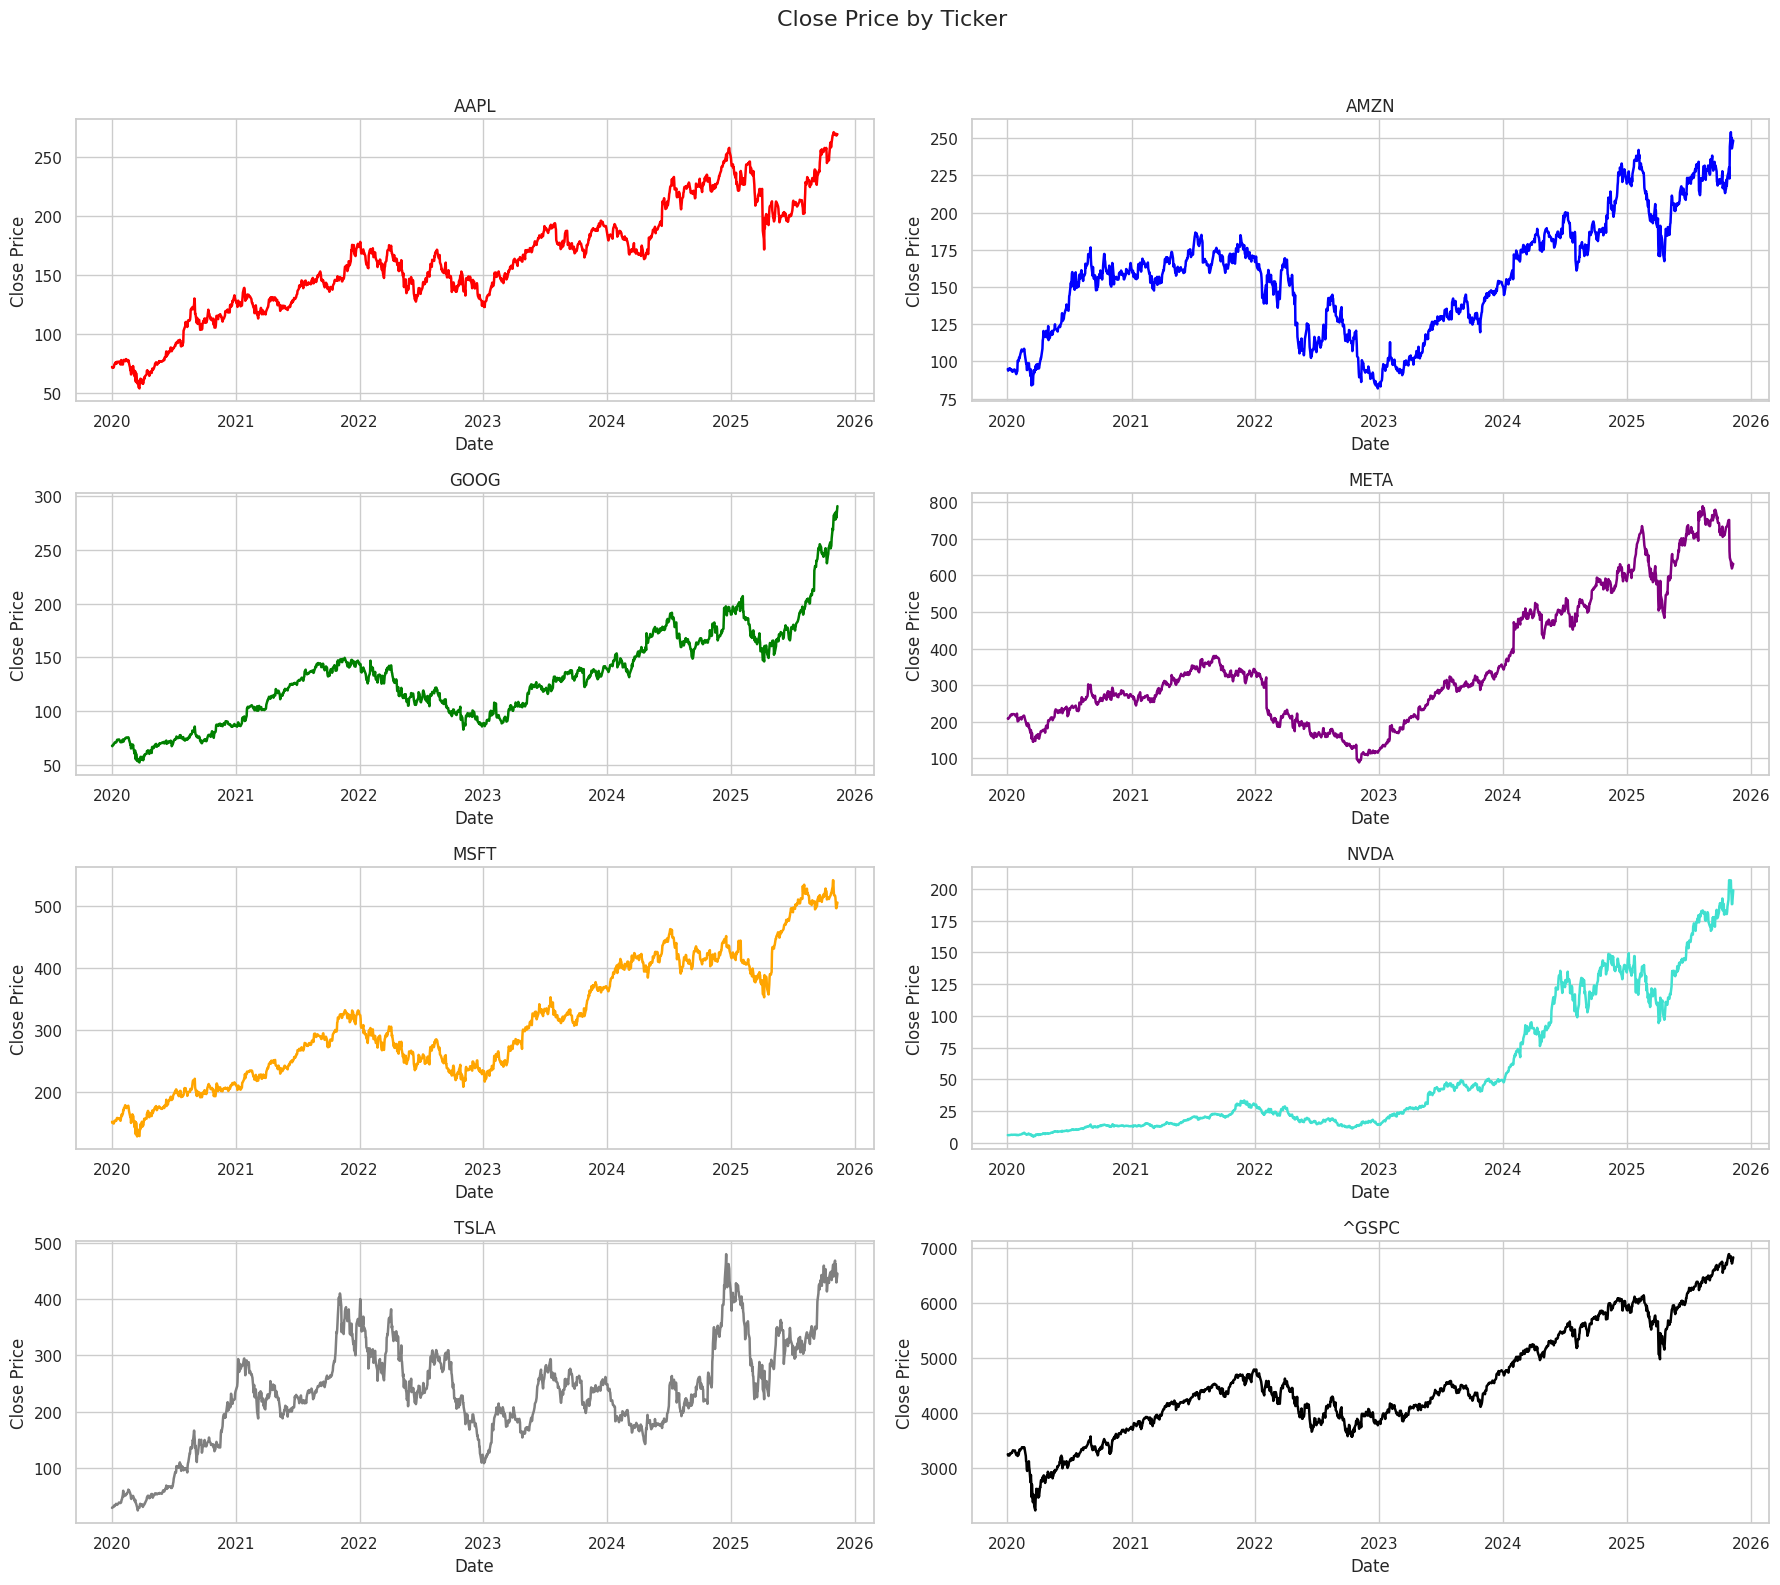

In [68]:
tickers = combined_df["Ticker"].dropna().unique()
colorlist = ['red', 'blue', 'green', 'purple', 'orange', 'turquoise', 'grey', 'black']

# Set grid size
n_rows, n_cols = 4, 2
n_panels = n_rows * n_cols

# Prepare figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 16), sharex=False, sharey=False)
axes = axes.flatten()

# Color cycler (so we don't index out of range)
color_cycler = cycle(colorlist)

# Limit to available panels to avoid IndexError
for ax, ticker in zip(axes, tickers[:n_panels]):
    data = combined_df[combined_df["Ticker"] == ticker].sort_values("Date")
    # Plot on the specific axis
    ax.plot(data["Date"], data["Close"], color=next(color_cycler), linewidth=1.8)
    ax.set_title(str(ticker), fontsize=12)
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Price")
    # Optional: nicer date formatting
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

# Hide any unused axes if fewer than n_panels tickers
for i in range(len(tickers), n_panels):
    axes[i].axis('off')

fig.suptitle("Close Price by Ticker", fontsize=16, y=0.99)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # leave room for the suptitle
plt.show()


## Closing and Open Price

Using a candle stick graph to show changes in open and close price. Doing weekly candles because dayly are too small to see.

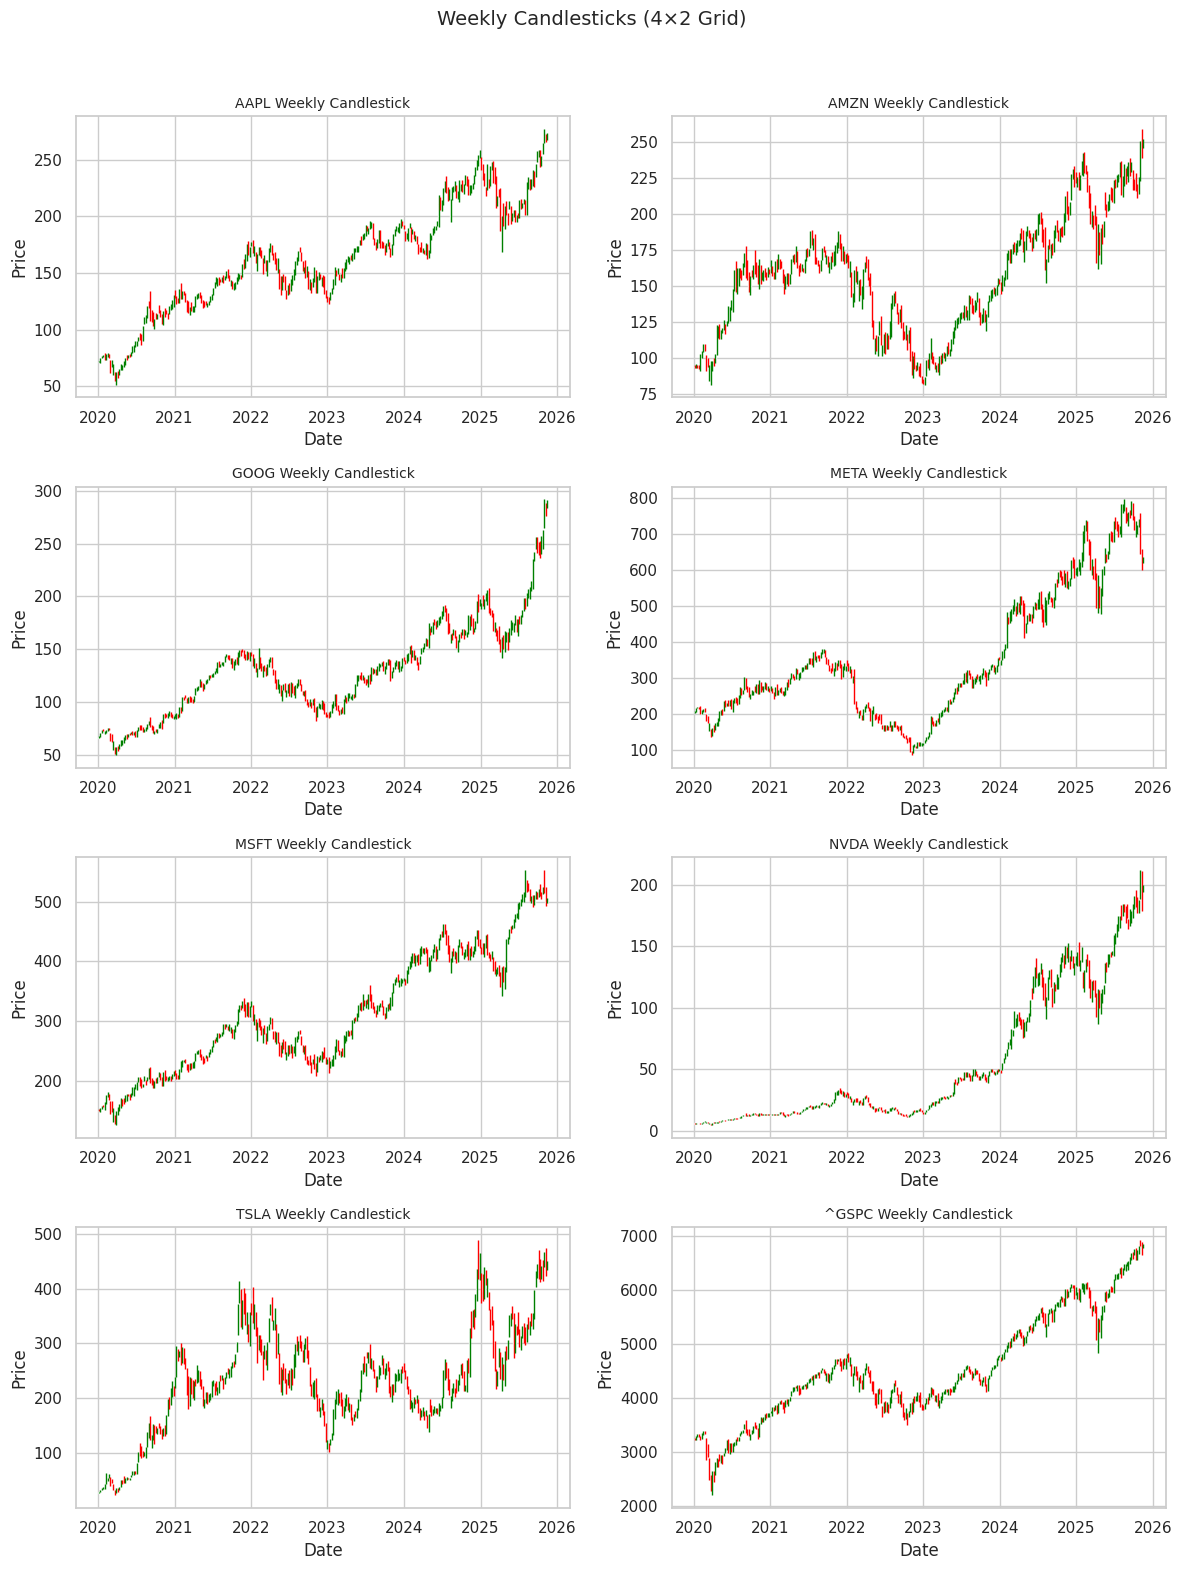

In [69]:
# Prepare tickers and grid config
tickers = combined_df["Ticker"].dropna().unique()
n_rows, n_cols = 4, 2
n_panels = n_rows * n_cols

# Create the figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 16), sharex=False, sharey=False)
axes = axes.flatten()

for ax, ticker in zip(axes, tickers[:n_panels]):
    # Filter and prepare data
    data = combined_df[combined_df["Ticker"] == ticker].copy()
    # Ensure Date is datetime and set as index
    data["Date"] = pd.to_datetime(data["Date"])
    data = data.sort_values("Date").set_index("Date")

    # Resample to weekly OHLC
    weekly = data.resample("W").agg({
        "Open": "first",
        "High": "max",
        "Low": "min",
        "Close": "last"
    }).dropna()

    if weekly.empty:
        ax.set_title(f"{ticker} (no weekly data)")
        ax.axis('off')
        continue

    # Candle colors: green if Close > Open, else red (ties will be red)
    colors = ["green" if c > o else "red" for o, c in zip(weekly["Open"], weekly["Close"])]

    # Plot wicks (high-low)
    ax.vlines(weekly.index, weekly["Low"], weekly["High"], color=colors, linewidth=1)

    # Plot candle bodies (open-close)
    # Width is in days for Matplotlib date plots 5 is weekly bar
    ax.bar(weekly.index, weekly["Close"] - weekly["Open"],
           bottom=weekly["Open"], color=colors, width=5, align='center')

    # Labels & title
    ax.set_title(f"{ticker} Weekly Candlestick", fontsize=10)
    ax.set_ylabel("Price")
    ax.set_xlabel("Date")

# Hide any unused axes if fewer than n_panels tickers
for i in range(len(tickers), n_panels):
    axes[i].axis('off')

# Overall figure formatting
fig.suptitle("Weekly Candlesticks (4×2 Grid)", fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Volume of Sales

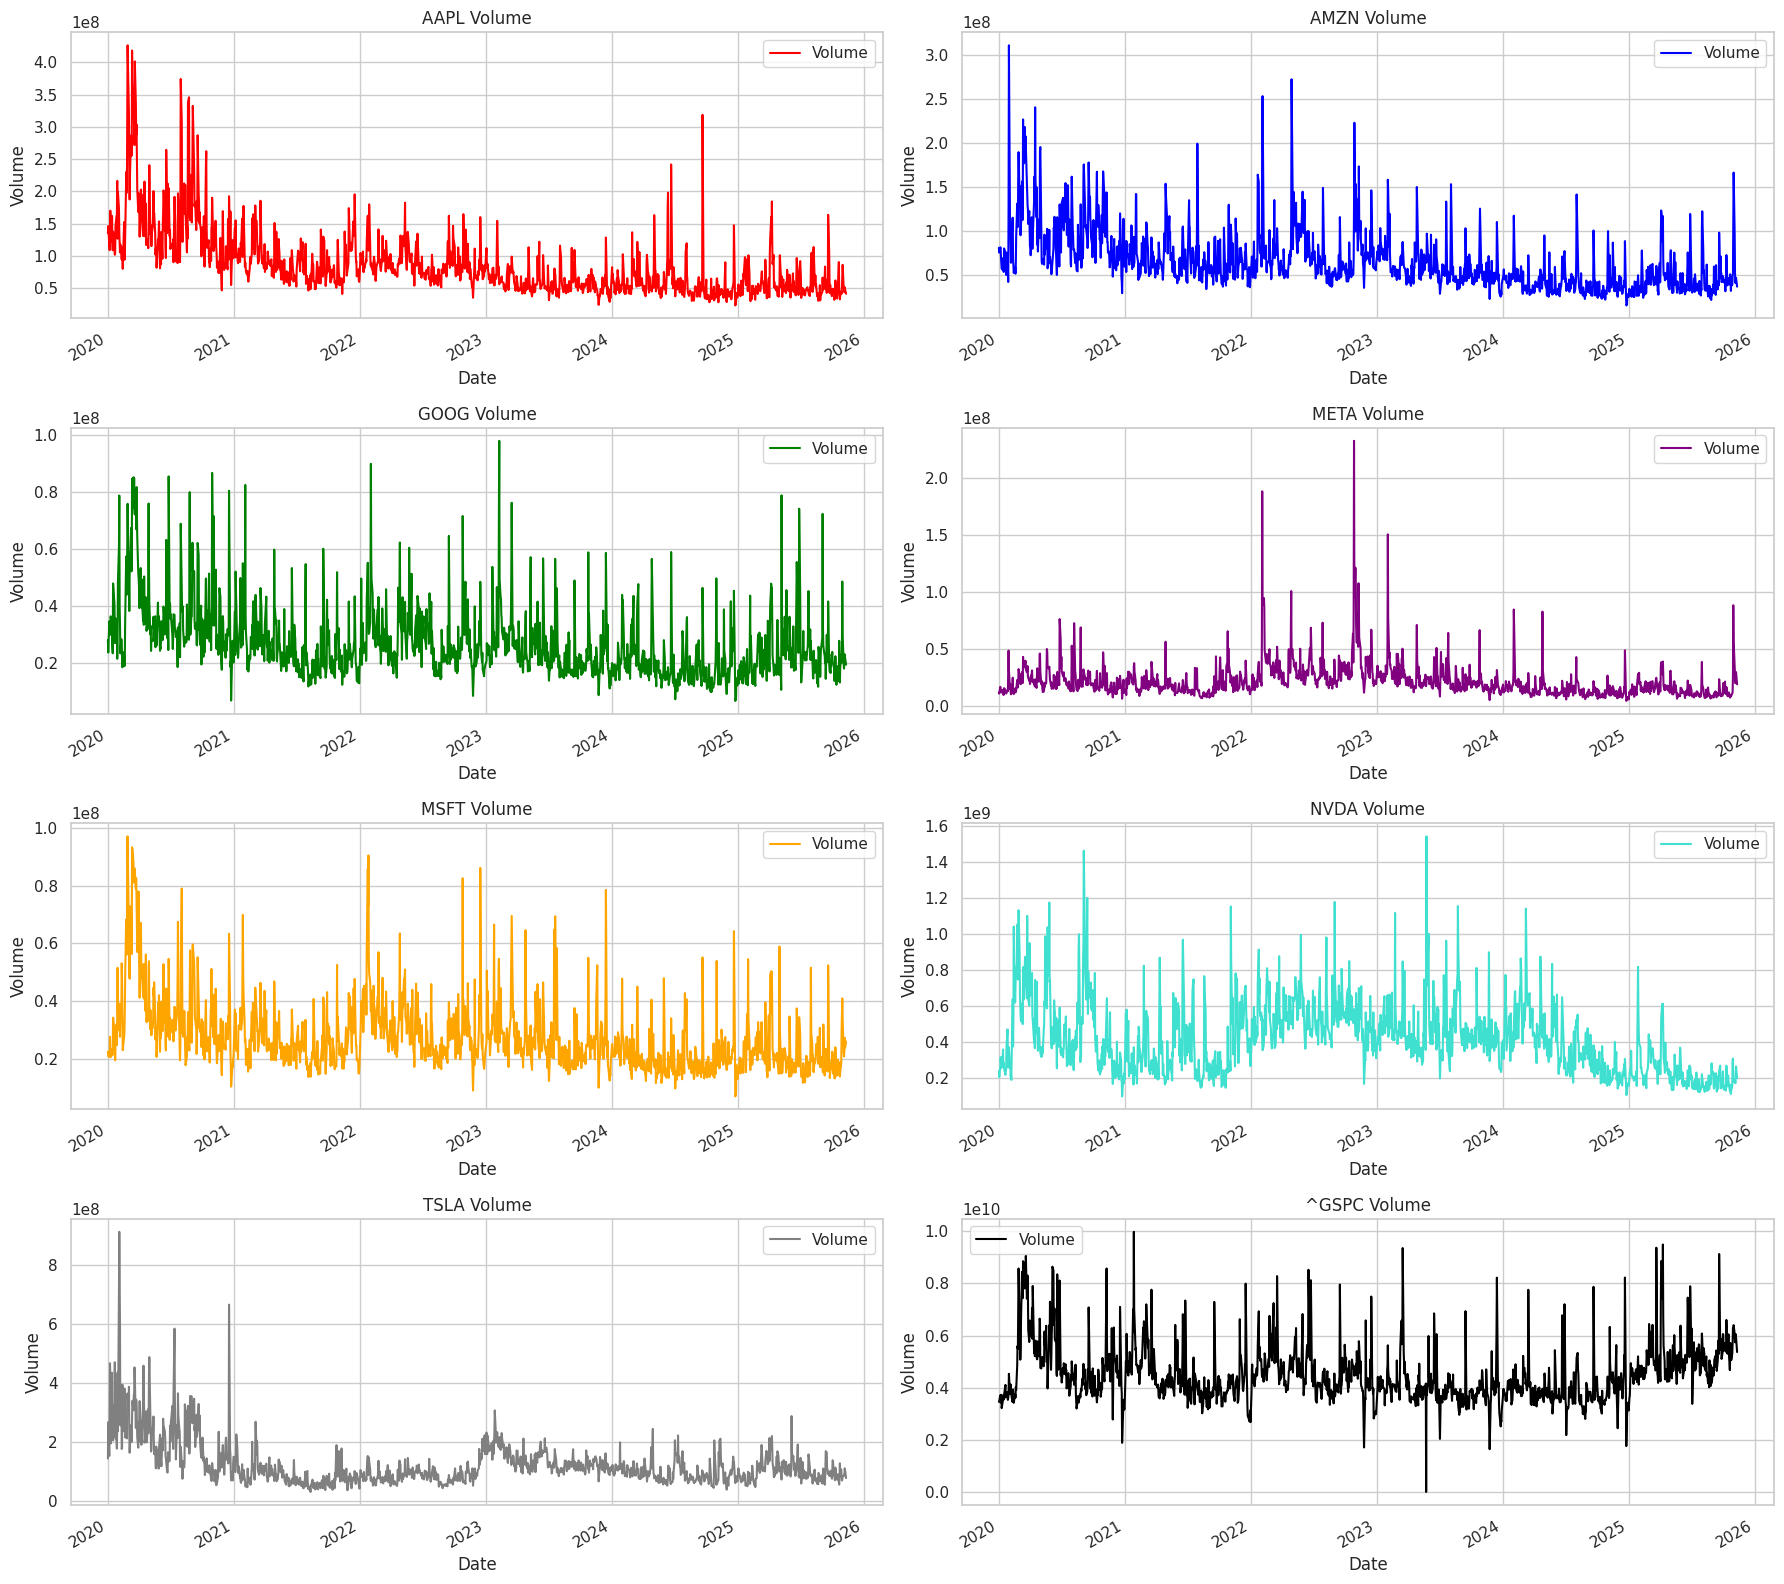

In [70]:
# Historial View of Sales Volumes 

plt.figure(figsize=(18, 16))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, ticker in enumerate(tickers, 1):
    plt.subplot(4, 2, i)
    data = combined_df[combined_df["Ticker"] == ticker]
    data.plot(x="Date", y="Volume", color=colorlist[i-1], ax=plt.gca())
    plt.ylabel('Volume')
    plt.xlabel('Date')
    plt.title(f"{ticker} Volume")

plt.tight_layout()

## Plotting Moving Averages

Moving averages provide an overall feel for how the stock is performing in a set period of time. It helps mitigate against the day to day volitility of the stock.

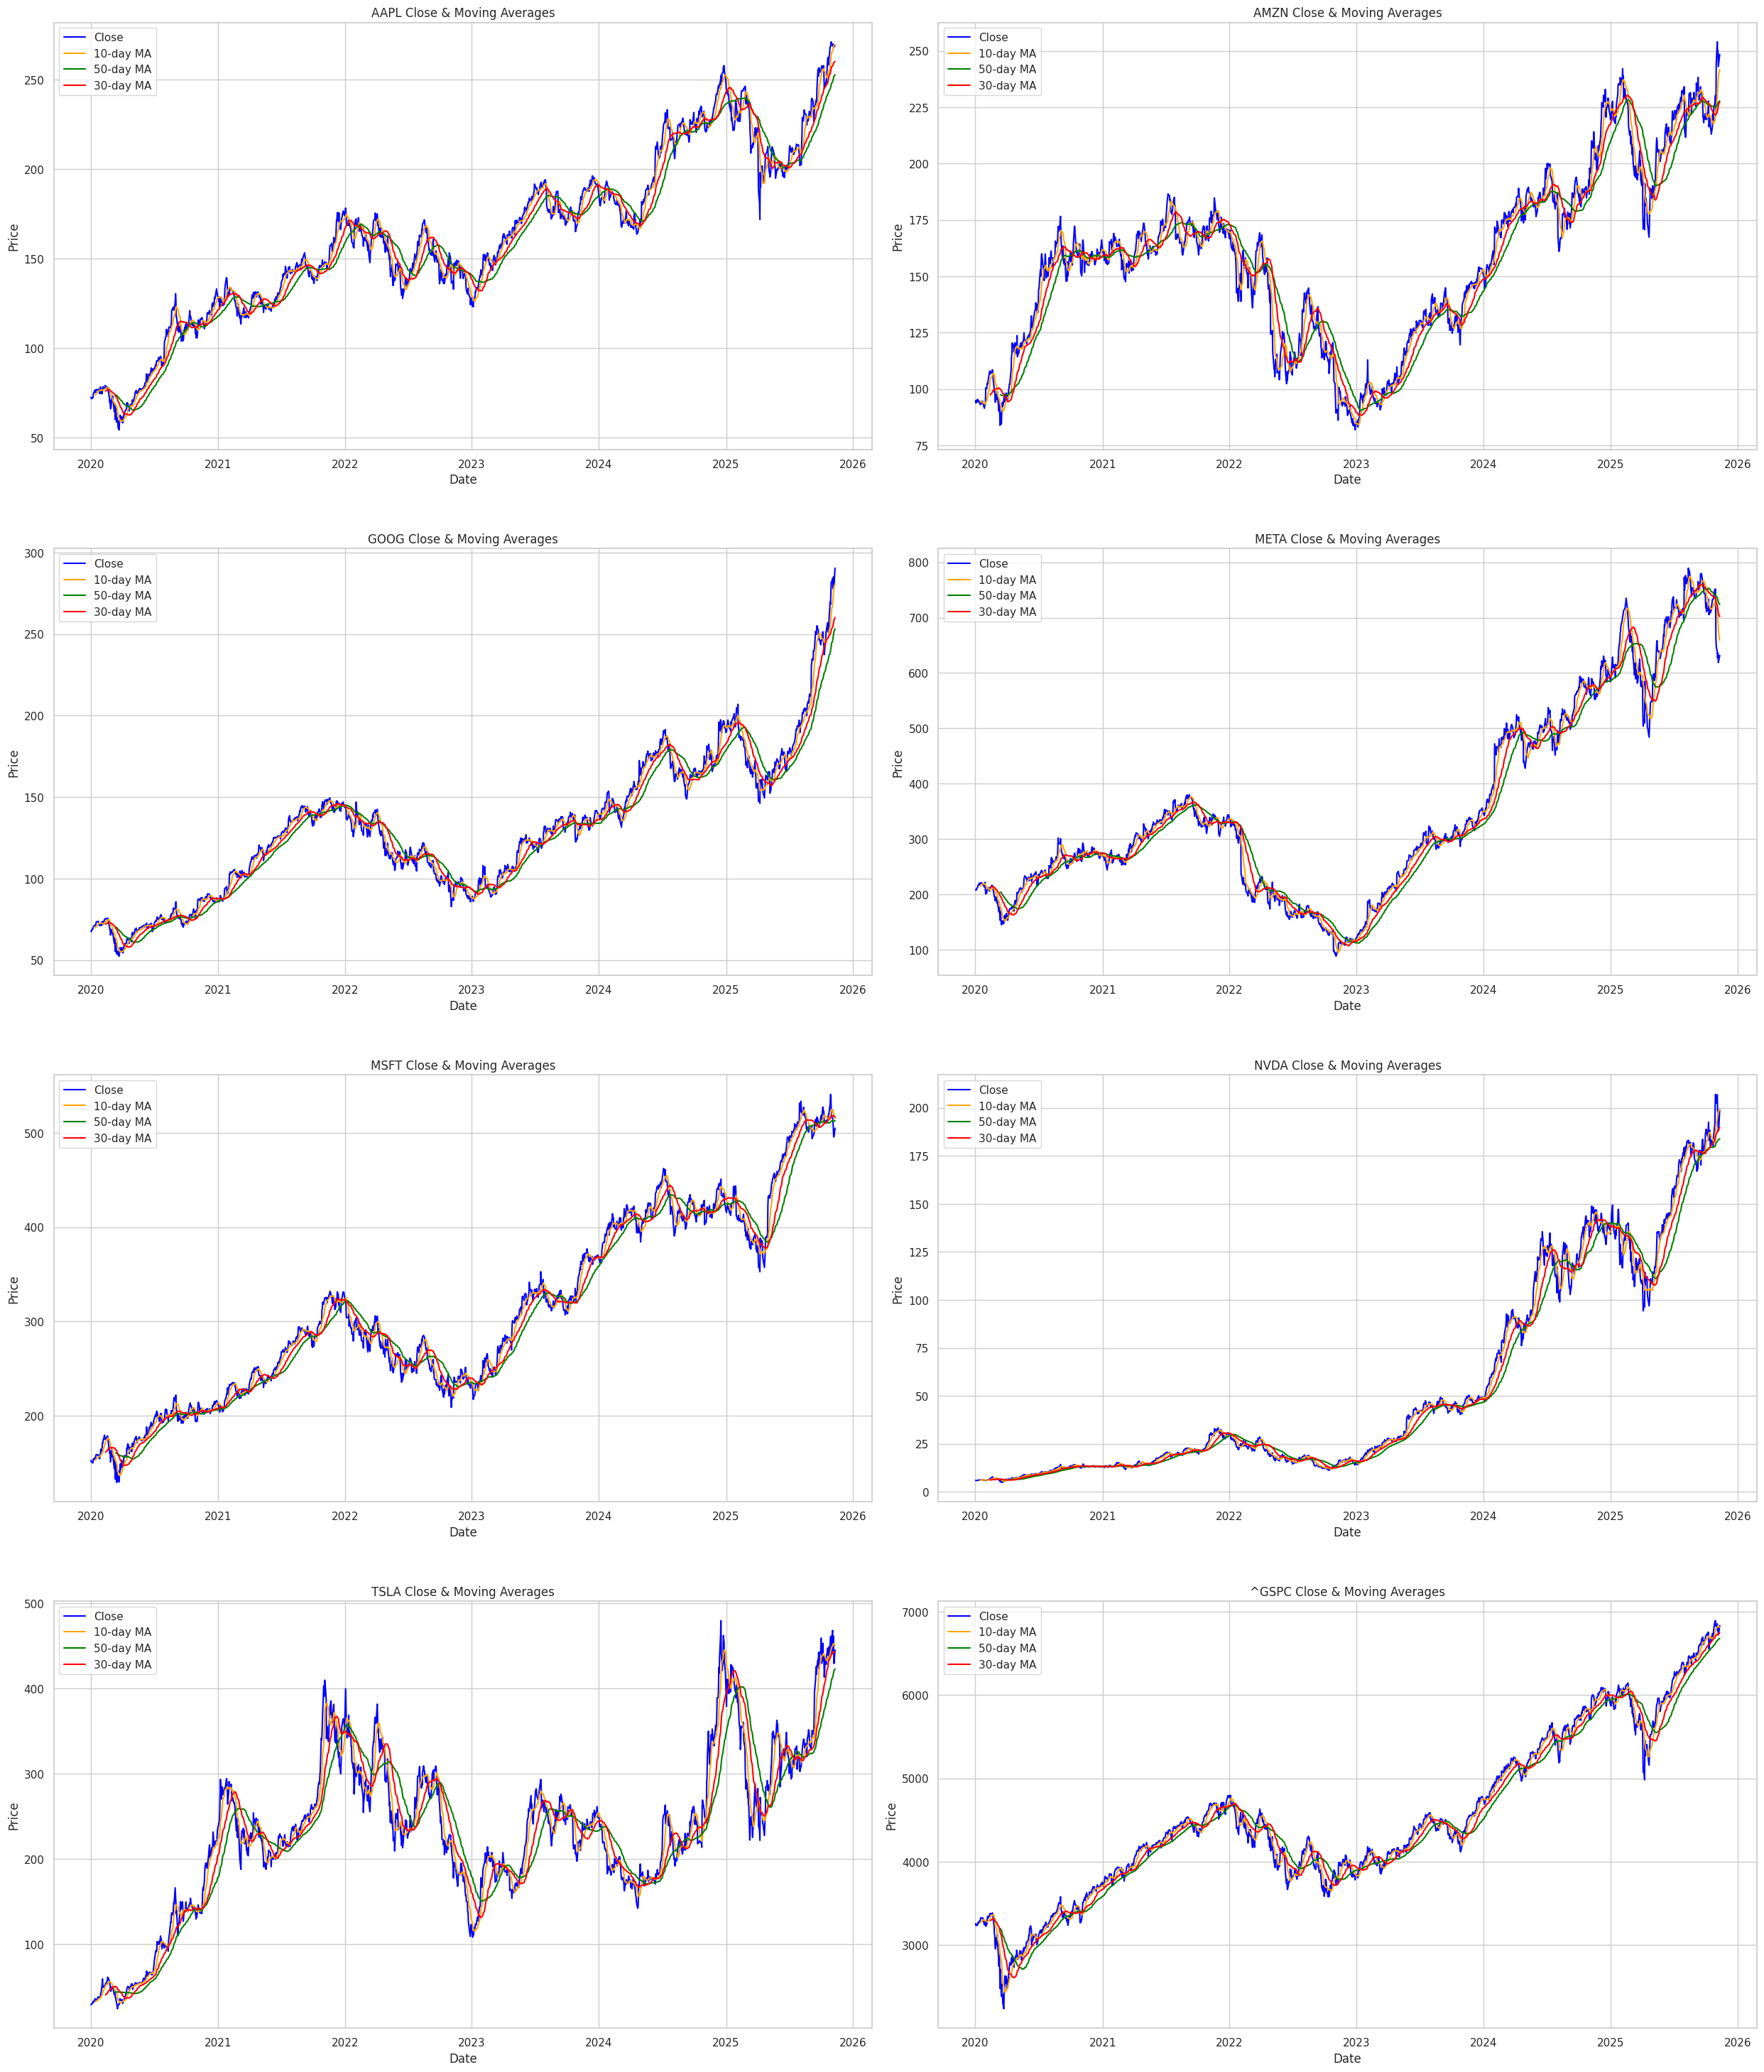

In [71]:

plt.figure(figsize=(25, 30))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, ticker in enumerate(tickers, 1):
    plt.subplot(4, 2, i)
    data = combined_df[combined_df["Ticker"] == ticker].copy()
    data = data.sort_values("Date")  # Ensure chronological order

    # Calculate moving averages
    data["MA10"] = data["Close"].rolling(window=10).mean()
    data["MA50"] = data["Close"].rolling(window=50).mean()
    data["MA30"] = data["Close"].rolling(window=30).mean()

    # Plot Close price
    plt.plot(data["Date"], data["Close"], label="Close", color="blue")
    # Plot moving averages
    plt.plot(data["Date"], data["MA10"], label="10-day MA", color="orange")
    plt.plot(data["Date"], data["MA50"], label="50-day MA", color="green")
    plt.plot(data["Date"], data["MA30"], label="30-day MA", color="red")

    plt.title(f"{ticker} Close & Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()

plt.tight_layout()
plt.show()


## Plotting Moving Averages Over 3 Year Time Frame

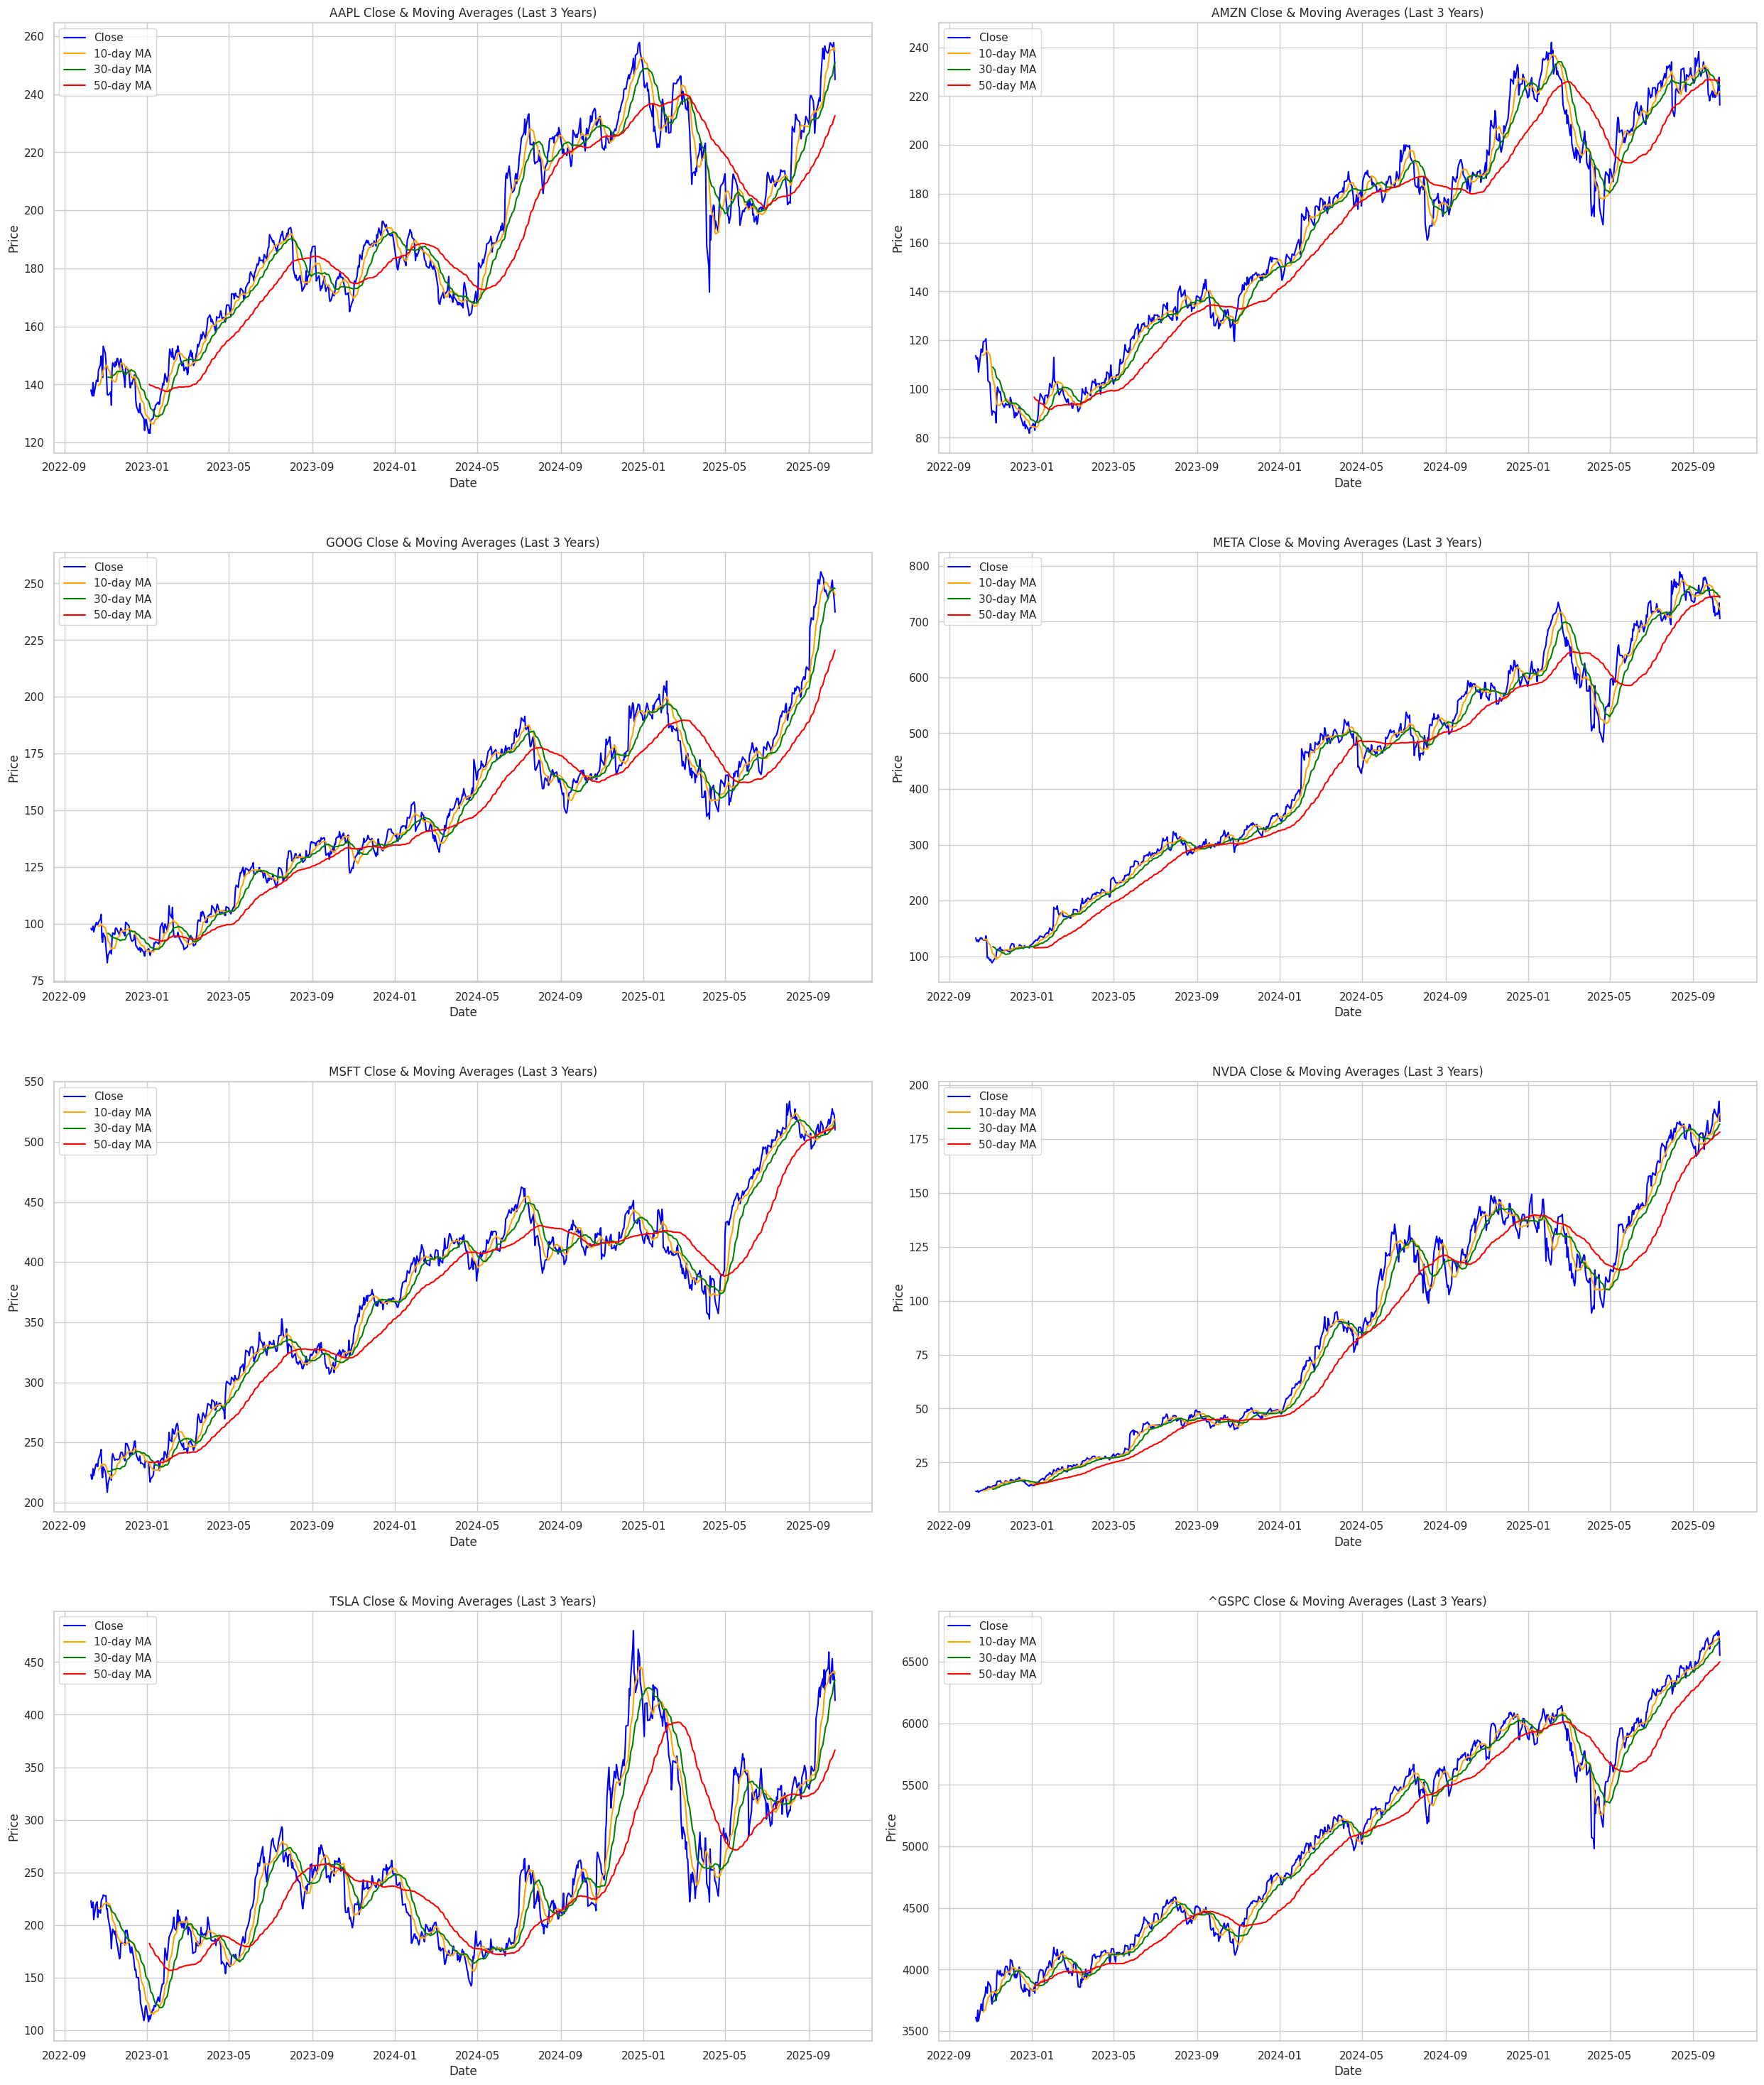

In [72]:
# Filter for last 5 years ending on 2025-10-10
end_date = pd.to_datetime('2025-10-10')
start_date = end_date - pd.DateOffset(years=3)
filtered_df = combined_df[(combined_df['Date'] >= start_date) & (combined_df['Date'] <= end_date)]

plt.figure(figsize=(25, 30))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, ticker in enumerate(tickers, 1):
    plt.subplot(4, 2, i)
    data = filtered_df[filtered_df['Ticker'] == ticker].copy()
    data = data.sort_values('Date')

    # Calculate moving averages
    data['MA10'] = data['Close'].rolling(window=10).mean()
    data['MA30'] = data['Close'].rolling(window=20).mean()
    data['MA50'] = data['Close'].rolling(window=60).mean()

    # Plot Close and MAs
    plt.plot(data['Date'], data['Close'], label='Close', color='blue')
    plt.plot(data['Date'], data['MA10'], label='10-day MA', color='orange')
    plt.plot(data['Date'], data['MA30'], label='30-day MA', color='green')
    plt.plot(data['Date'], data['MA50'], label='50-day MA', color='red')

    plt.title(f"{ticker} Close & Moving Averages (Last 3 Years)")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

plt.tight_layout()


## Daily Stock Return

Calculated as a percentage

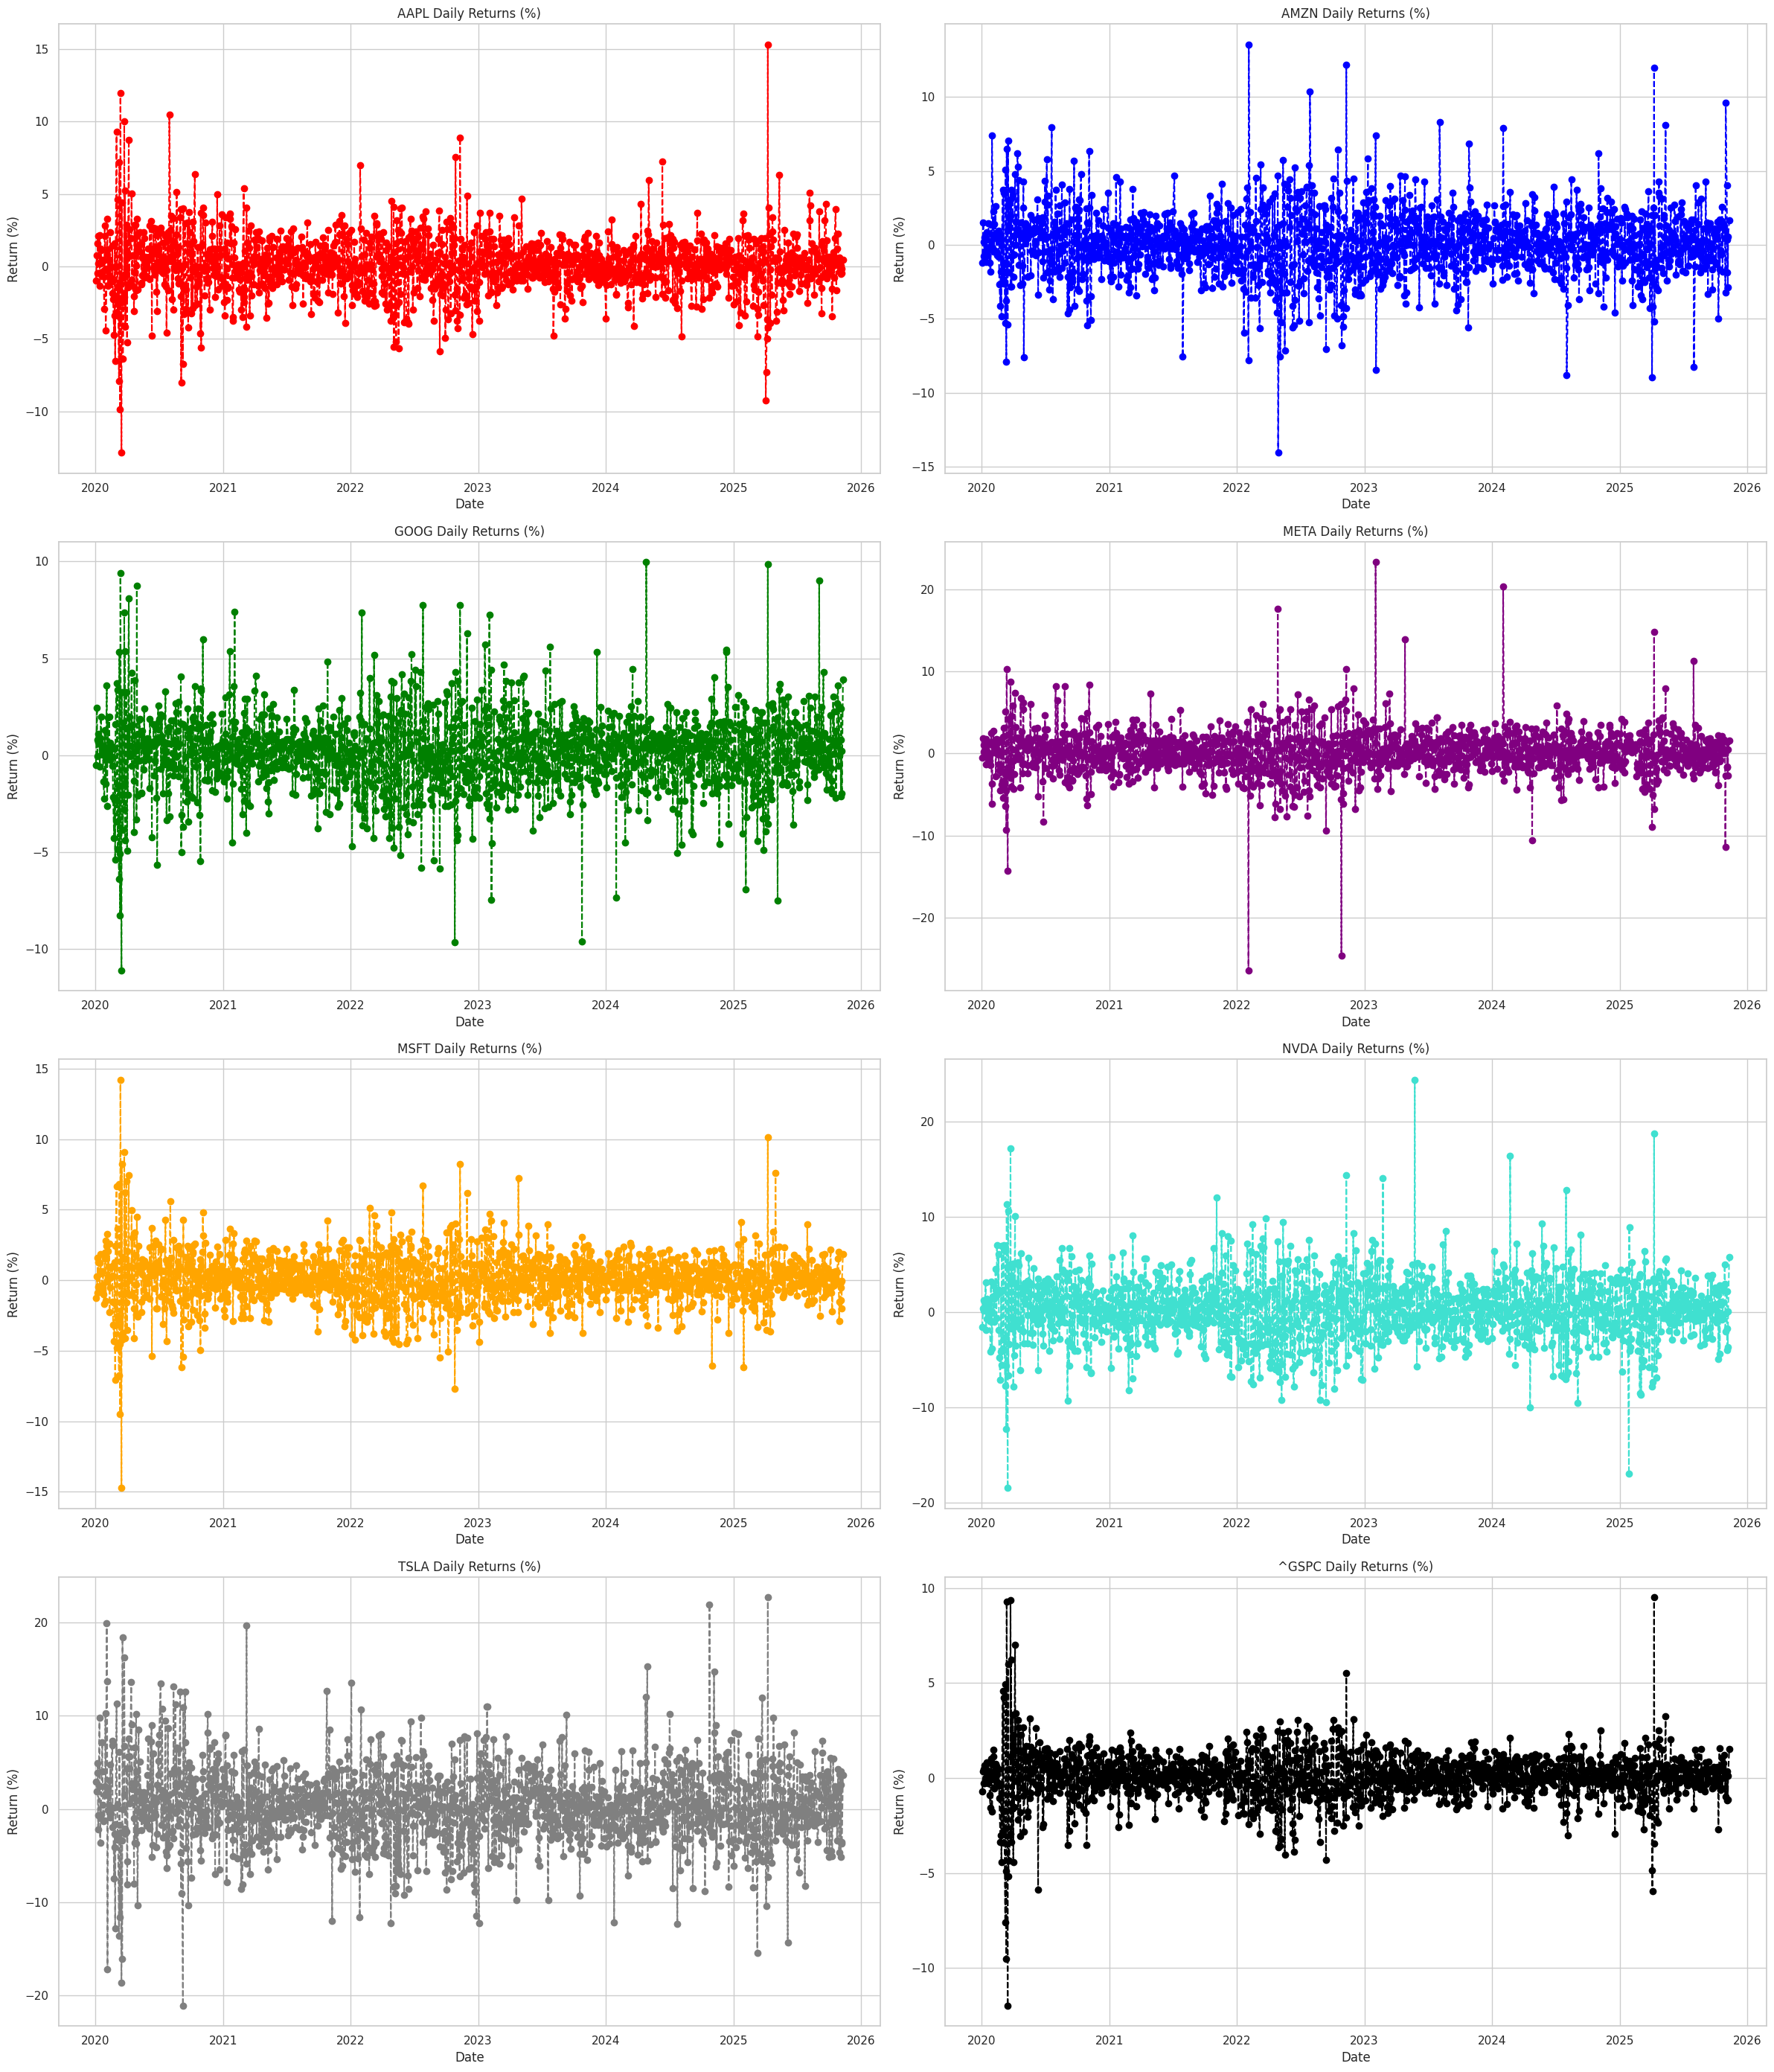

In [73]:
plt.figure(figsize=(24, 28))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, ticker in enumerate(tickers, 1):
    plt.subplot(4, 2, i)
    data = combined_df[combined_df['Ticker'] == ticker].copy()
    data = data.sort_values('Date')

    # Calculate daily percentage return
    data['Daily_Return_%'] = data['Close'].pct_change() * 100

    # Plot daily returns
    plt.plot(data['Date'], data['Daily_Return_%'], linestyle='--', marker='o', color=colorlist[i-1])
    
    plt.title(f"{ticker} Daily Returns (%)")
    plt.xlabel('Date')
    plt.ylabel('Return (%)')
   

plt.tight_layout()


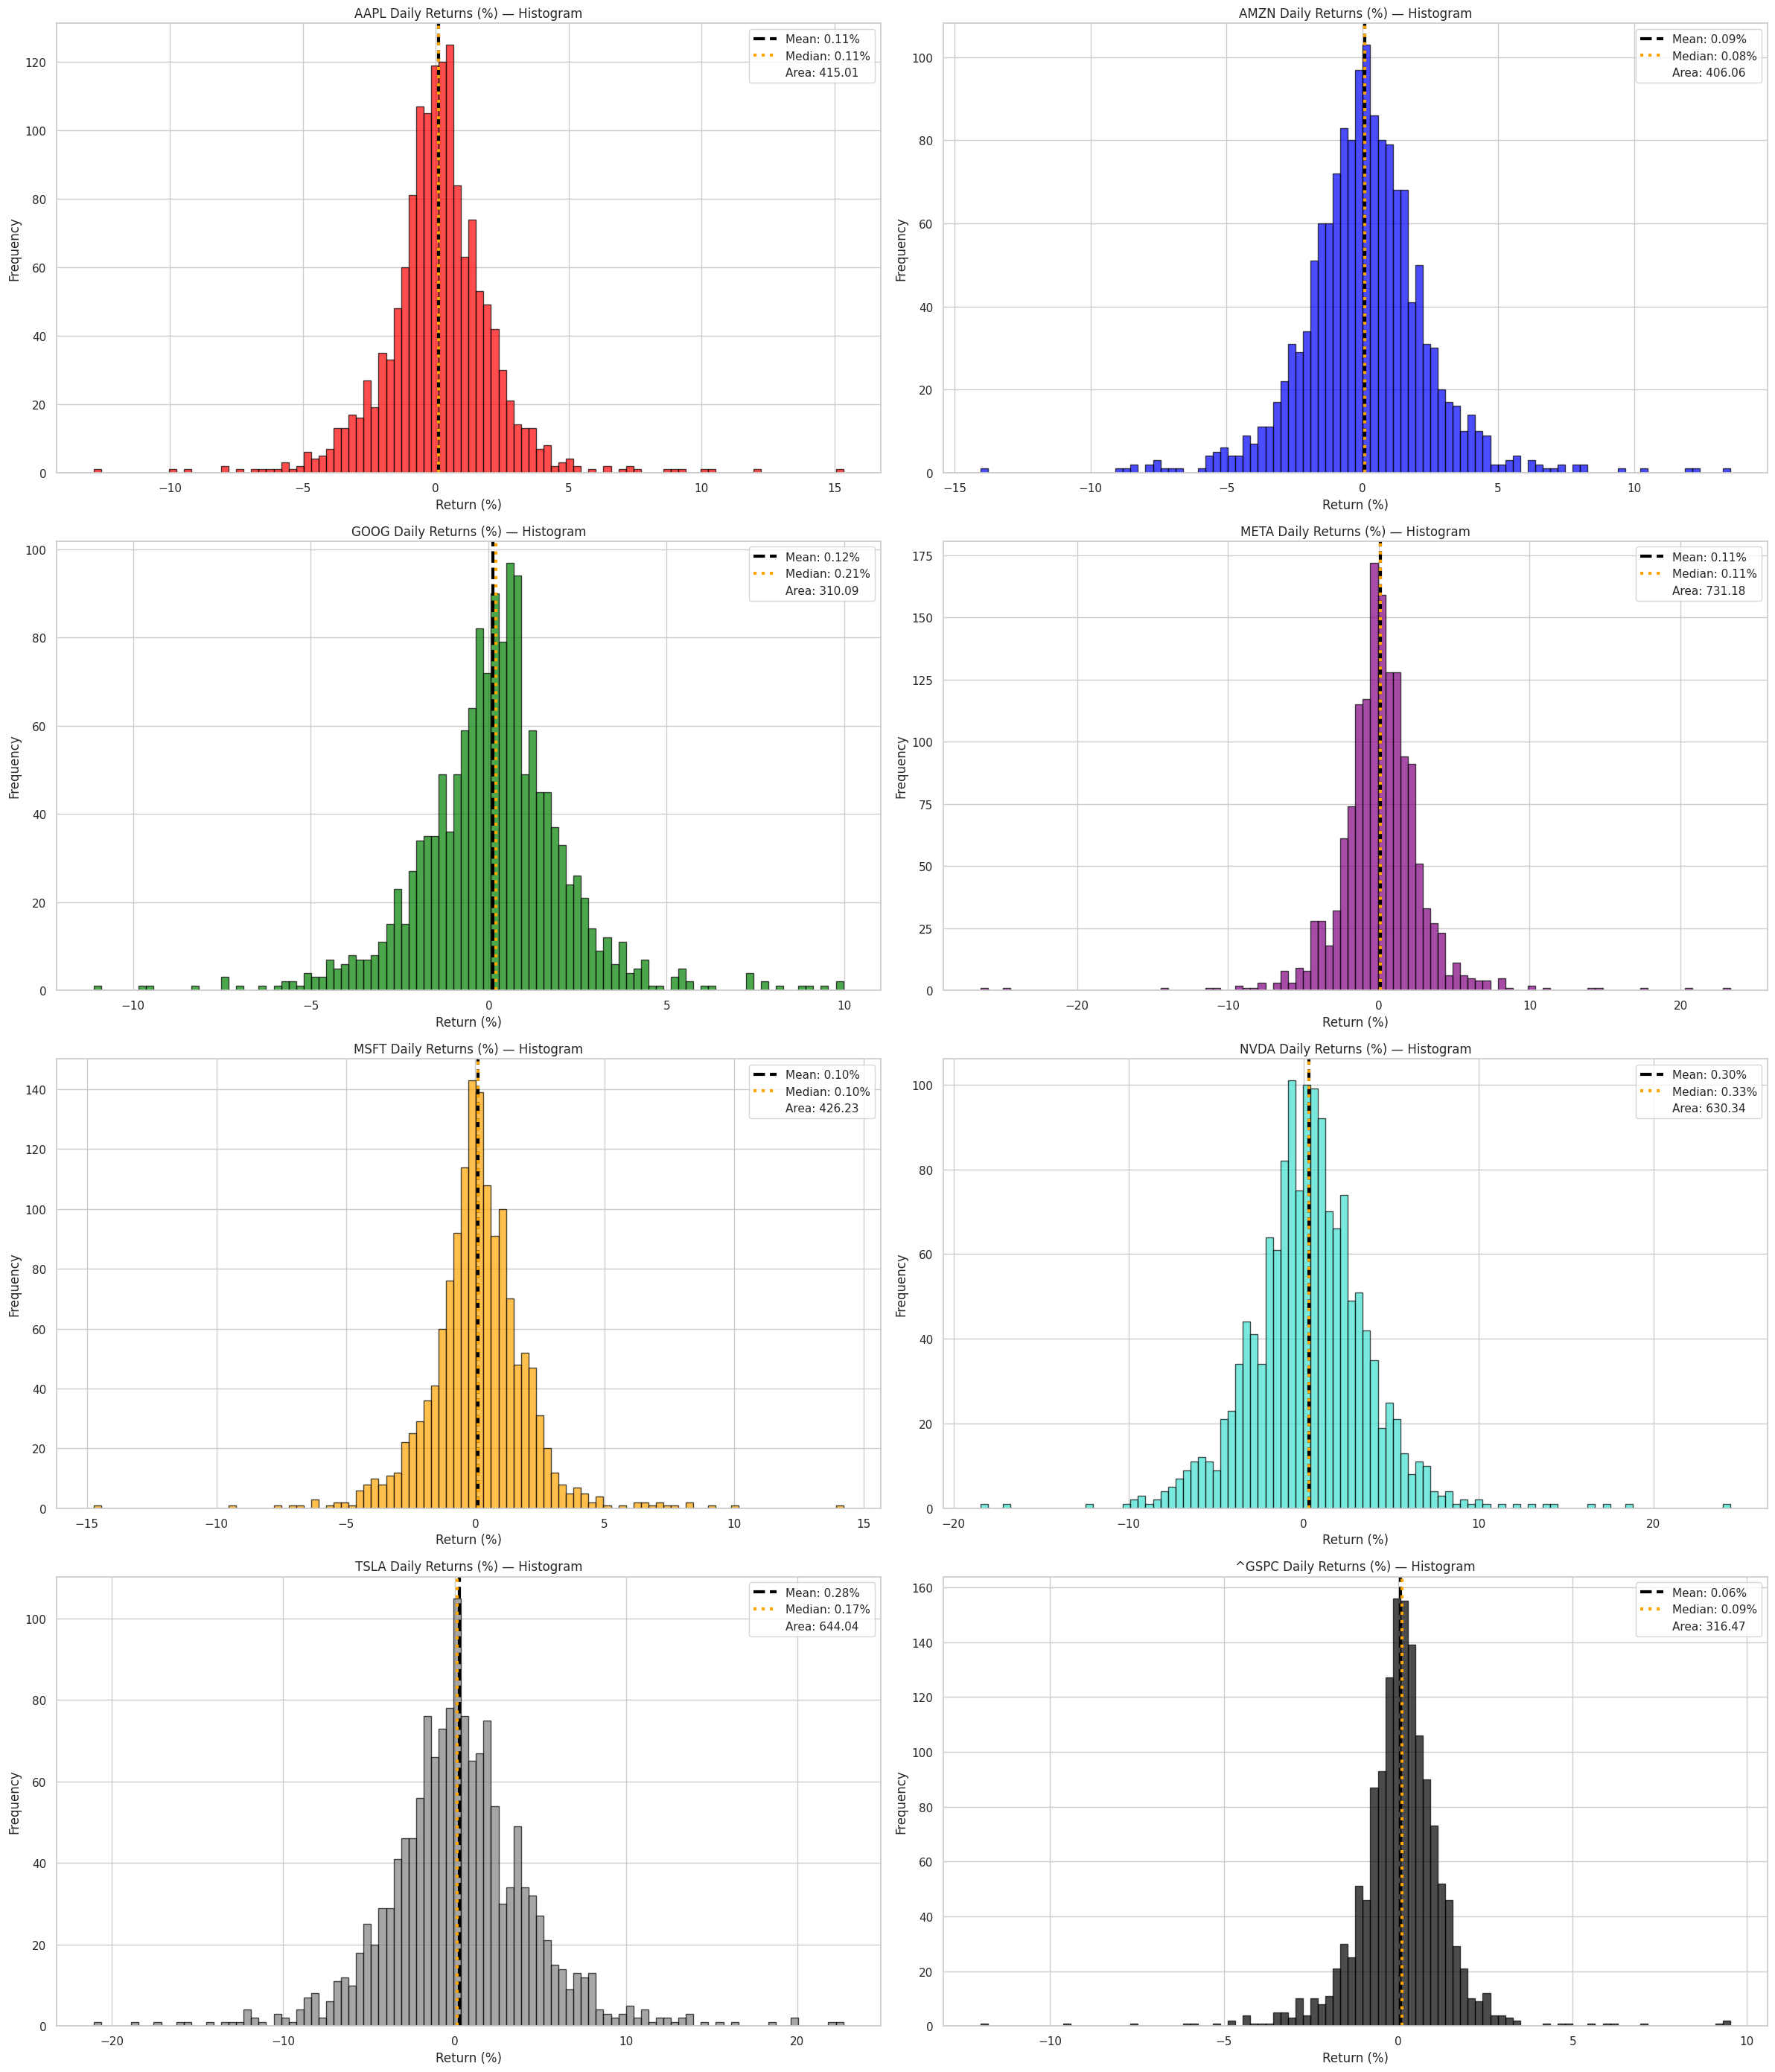

In [74]:
plt.figure(figsize=(24, 28))
plt.subplots_adjust(top=1.25, bottom=0.1)

for i, ticker in enumerate(tickers, 1):
    plt.subplot(4, 2, i)
    data = combined_df[combined_df['Ticker'] == ticker].copy()
    data = data.sort_values('Date')

    # Daily percentage return
    data['Daily_Return_%'] = data['Close'].pct_change() * 100
    returns = data['Daily_Return_%'].dropna()

    # Summary stats
    mean_val = returns.mean()
    median_val = returns.median()

    # Histogram
    bins = 100
    n, bin_edges, patches = plt.hist(
        returns,
        bins=bins,
        color=colorlist[i-1],
        alpha=0.7,
        edgecolor='black'
    )

    # Histogram area
    bin_widths = np.diff(bin_edges)
    area = np.sum(n * bin_widths)

    # Lines for mean & median
    plt.axvline(mean_val, color='black', linestyle='--', linewidth=3, label=f"Mean: {mean_val:.2f}%")
    plt.axvline(median_val, color='orange', linestyle=':', linewidth=3, label=f"Median: {median_val:.2f}%")
    plt.plot([], [], ' ', label=f"Area: {area:.2f}")  # empty handle just to show text in legend

    plt.title(f"{ticker} Daily Returns (%) — Histogram")
    plt.xlabel('Return (%)')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()


In [75]:
from scipy.stats import kurtosis, skew

tickers = combined_df["Ticker"].unique()

for ticker in tickers:
    data = combined_df[combined_df["Ticker"] == ticker].copy()
    data = data.sort_values("Date")

    data["Daily_Return_%"] = data["Close"].pct_change() * 100
    returns = data["Daily_Return_%"].dropna()

    # Compute skewness and kurtosis
    skew_val = skew(returns)
    kurt_val = kurtosis(returns, fisher=True)  # fisher=True gives excess kurtosis

    print(f"{ticker}: Skewness = {skew_val:.4f}, Kurtosis = {kurt_val:.4f}")


AAPL: Skewness = 0.2800, Kurtosis = 6.6277
AMZN: Skewness = 0.1409, Kurtosis = 4.2708
GOOG: Skewness = -0.0157, Kurtosis = 3.6372
META: Skewness = -0.1911, Kurtosis = 17.2421
MSFT: Skewness = 0.1052, Kurtosis = 7.4493
NVDA: Skewness = 0.3461, Kurtosis = 4.4462
TSLA: Skewness = 0.2396, Kurtosis = 3.2604
^GSPC: Skewness = -0.3280, Kurtosis = 13.6730


**AAPL**

Skewness (0.2800): Slight positive skew → occasional extreme high prices, but overall fairly symmetric.
Kurtosis (6.63): Heavy tails → more frequent large price moves than a normal distribution, indicating volatility spikes.


**AMZN**

Skewness (0.1409): Mild positive skew → distribution leans slightly toward higher prices.
Kurtosis (4.27): Above normal → moderate tail risk, suggesting occasional sharp price changes.


**GOOG**

Skewness (-0.0157): Almost zero → very symmetric distribution.
Kurtosis (3.64): Slightly above normal → some tail risk, but relatively stable compared to others.


**META**

Skewness (-0.1911): Slight negative skew → more extreme low-price outliers.
Kurtosis (17.24): Extremely high → very fat tails, strong presence of extreme price movements (high volatility episodes).


**MSFT**

Skewness (0.1052): Mild positive skew → slightly more high-price outliers.
Kurtosis (7.45): Heavy tails → significant tail risk, indicating large price swings occur more often than normal.


**NVDA**

Skewness (0.3461): Strongest positive skew → distribution tilts toward high-price outliers.
Kurtosis (4.45): Moderate tail risk → volatility is present but less extreme than META.


**TSLA**

Skewness (0.2396): Positive skew → more high-price outliers.
Kurtosis (3.26): Closest to normal among the group → still some tail risk, but relatively less extreme.


**^GSPC (S&P 500)**

Skewness (-0.3280): Negative skew → more downside risk, meaning extreme low-price events are more common.
Kurtosis (13.67): Very high → fat tails, indicating strong susceptibility to large shocks.
Impact of Magnificent 7: These stocks (AAPL, AMZN, GOOG, META, MSFT, NVDA, TSLA) dominate S&P 500 weighting. Their high kurtosis and occasional skew amplify tail risk for the index. For example:

META’s extreme kurtosis and NVDA’s positive skew can create upward surges.
Negative skew in ^GSPC suggests that when these stocks drop sharply (e.g., META or TSLA corrections), the index experiences outsized downside moves.
Overall, concentration in these volatile stocks makes the S&P 500 more prone to fat tails and asymmetric risk.





## Joinplots to Compare Daily Returns of Stocks

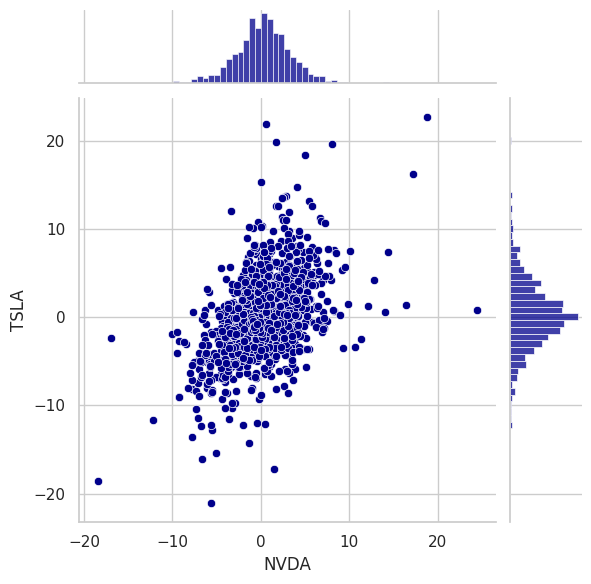

In [76]:

returns_df = combined_df.copy()
returns_df = returns_df.sort_values(['Ticker', 'Date'])
returns_df['Daily_Return_%'] = returns_df.groupby('Ticker')['Close'].pct_change() * 100

# Pivot so each ticker is a column
pivot_returns = returns_df.pivot(index='Date', columns='Ticker', values='Daily_Return_%').dropna()

sns.jointplot(x='NVDA', y='TSLA', data=pivot_returns, kind='scatter', color='darkblue')

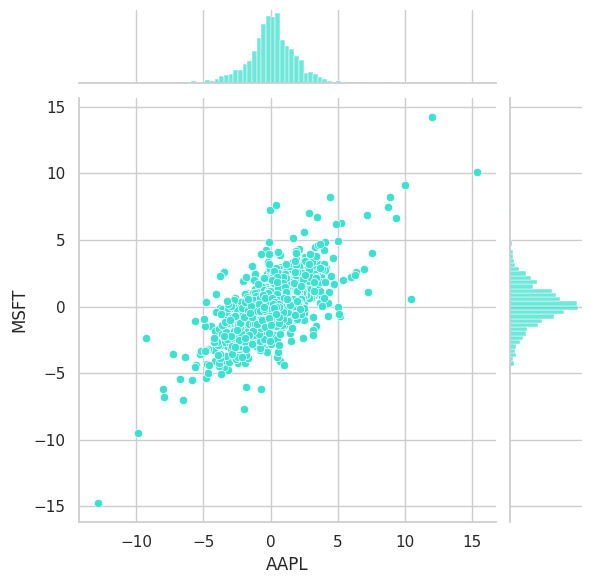

In [77]:
sns.jointplot(x='AAPL', y='MSFT', data=pivot_returns, kind='scatter', color='turquoise')

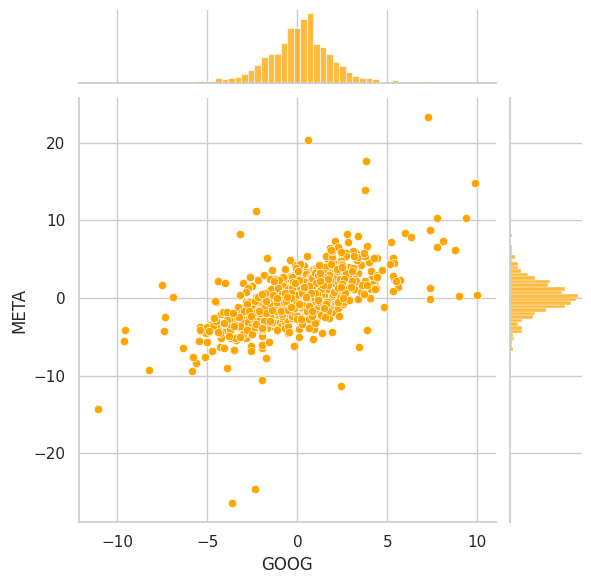

In [78]:
sns.jointplot(x='GOOG', y='META', data=pivot_returns, kind='scatter', color='orange')

Text(0.5, 1.02, 'Pairwise Comparison of Daily Percentage Returns')

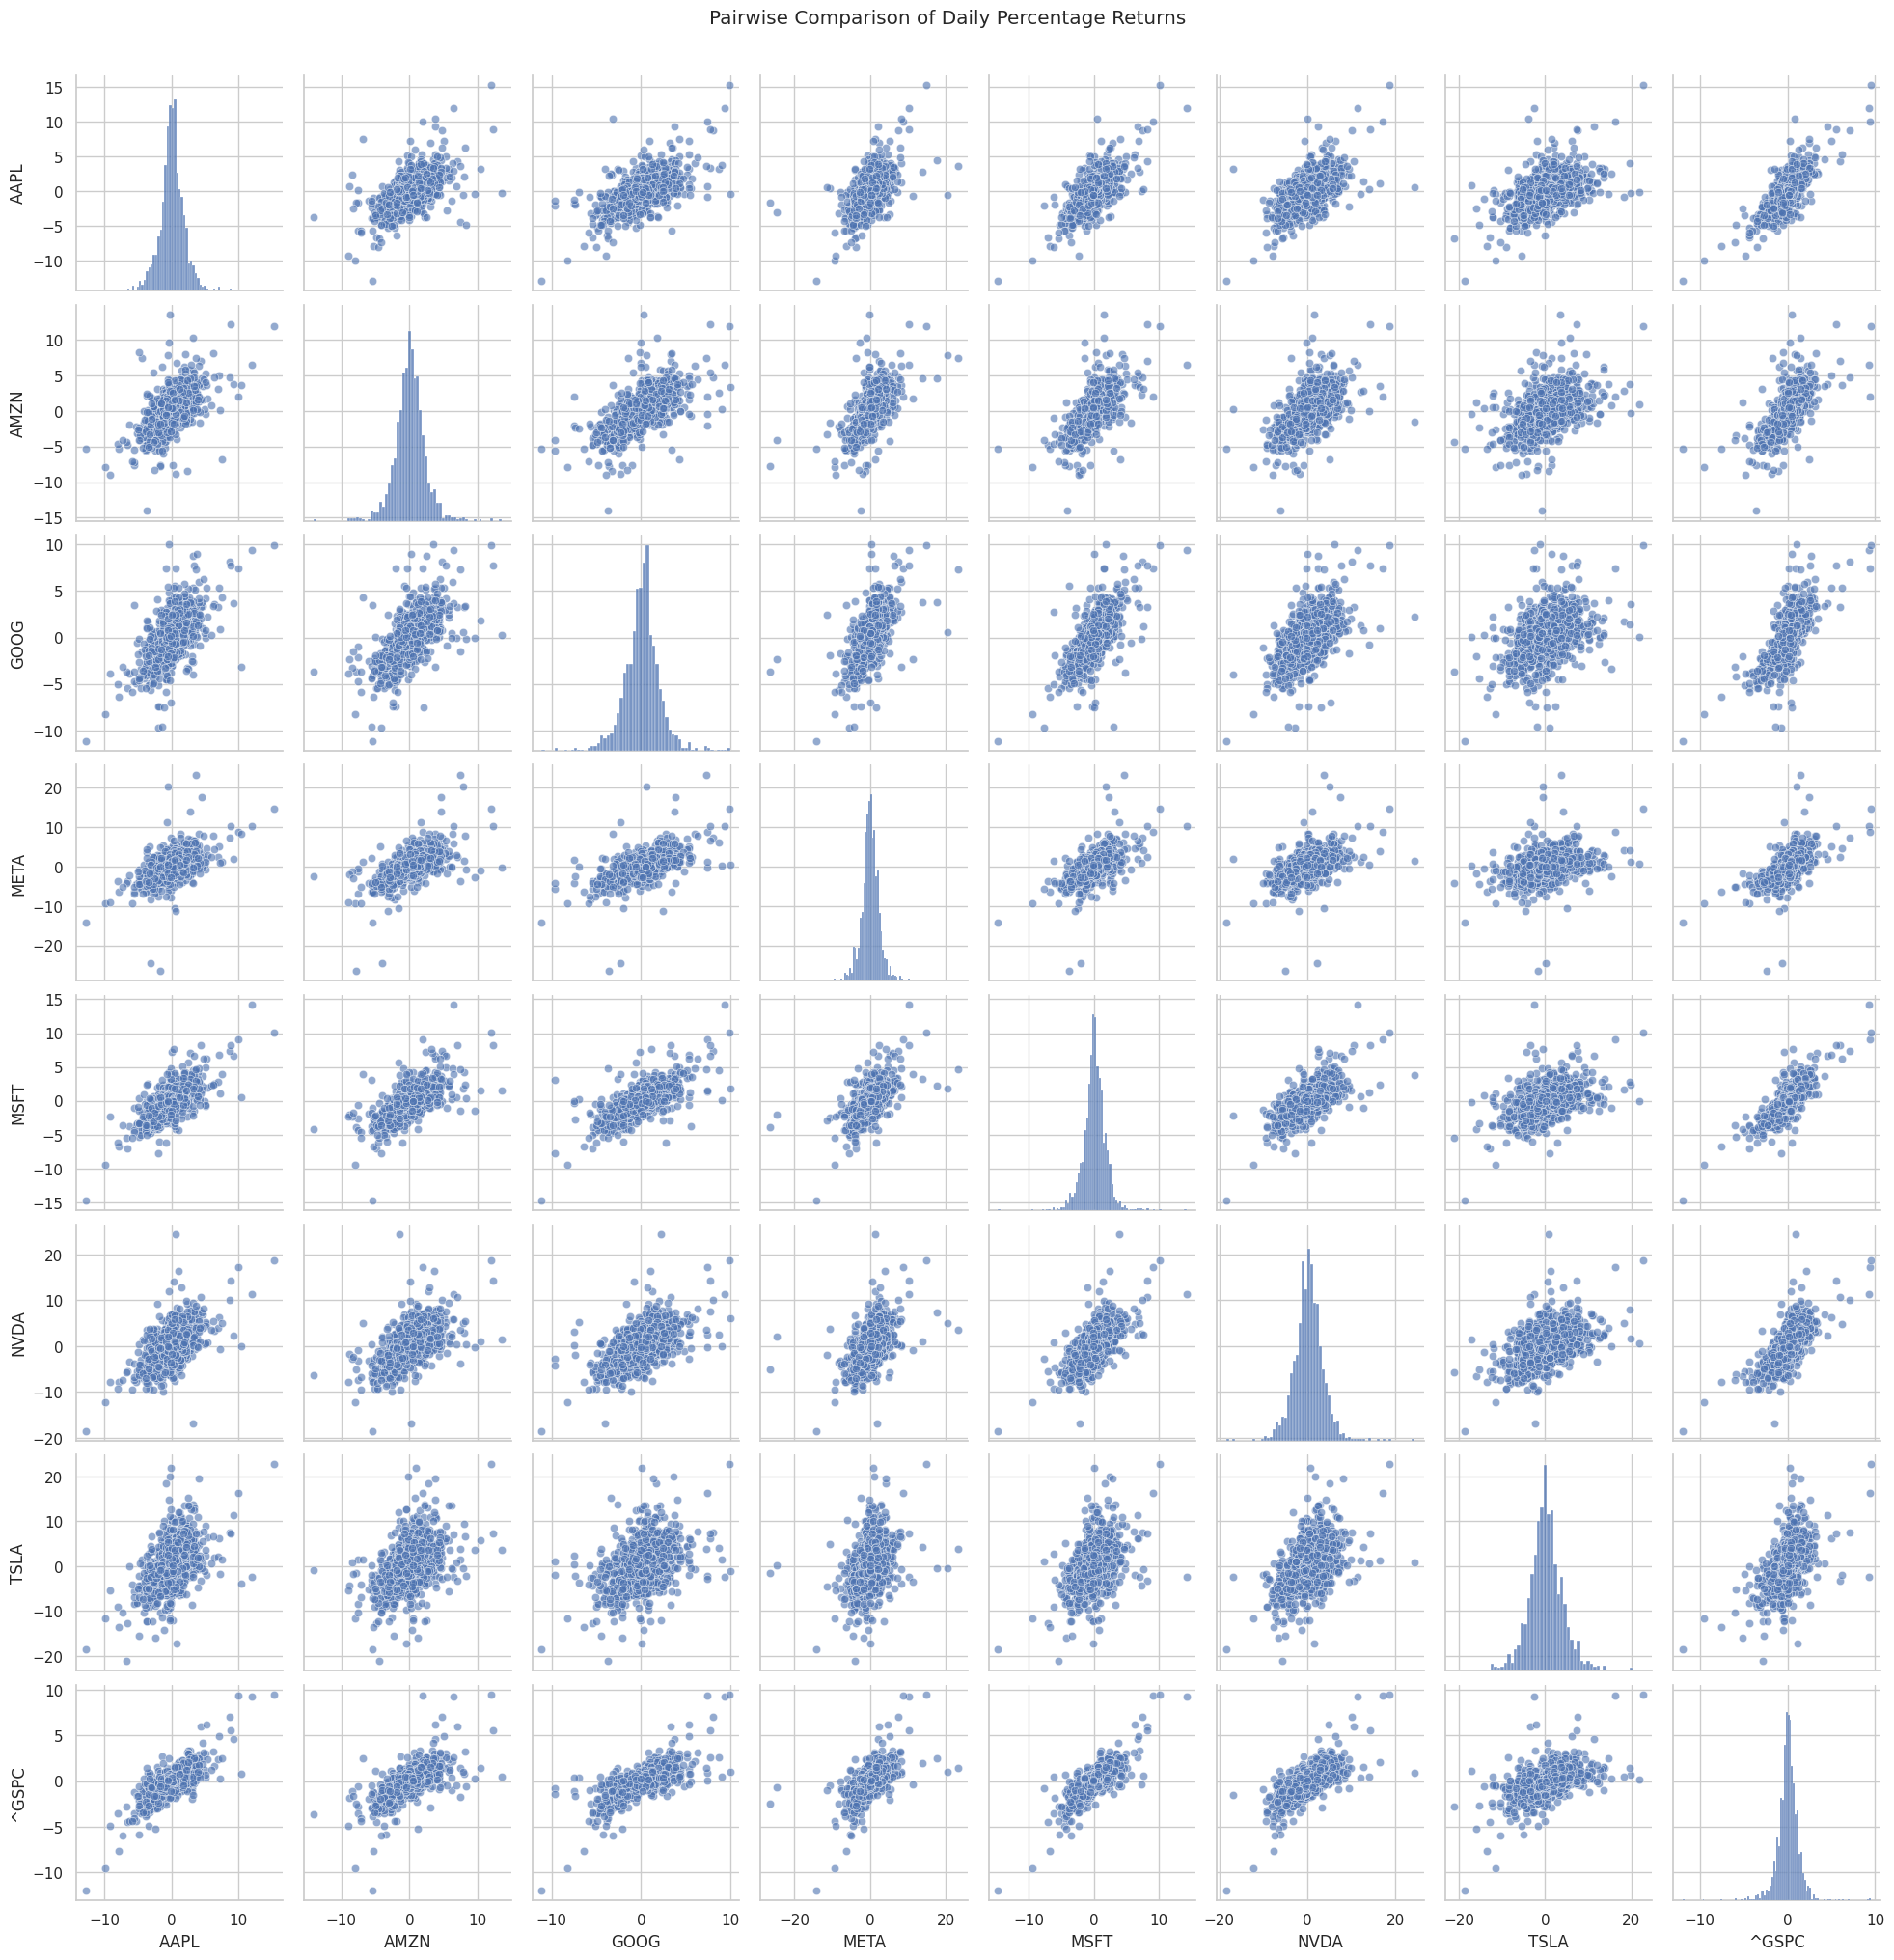

In [79]:
# Create pairplot
sns.set(style="whitegrid")
pairplot = sns.pairplot(pivot_returns, kind='scatter', diag_kind='hist', plot_kws={'alpha':0.6})
pairplot.fig.suptitle("Pairwise Comparison of Daily Percentage Returns", y=1.02)


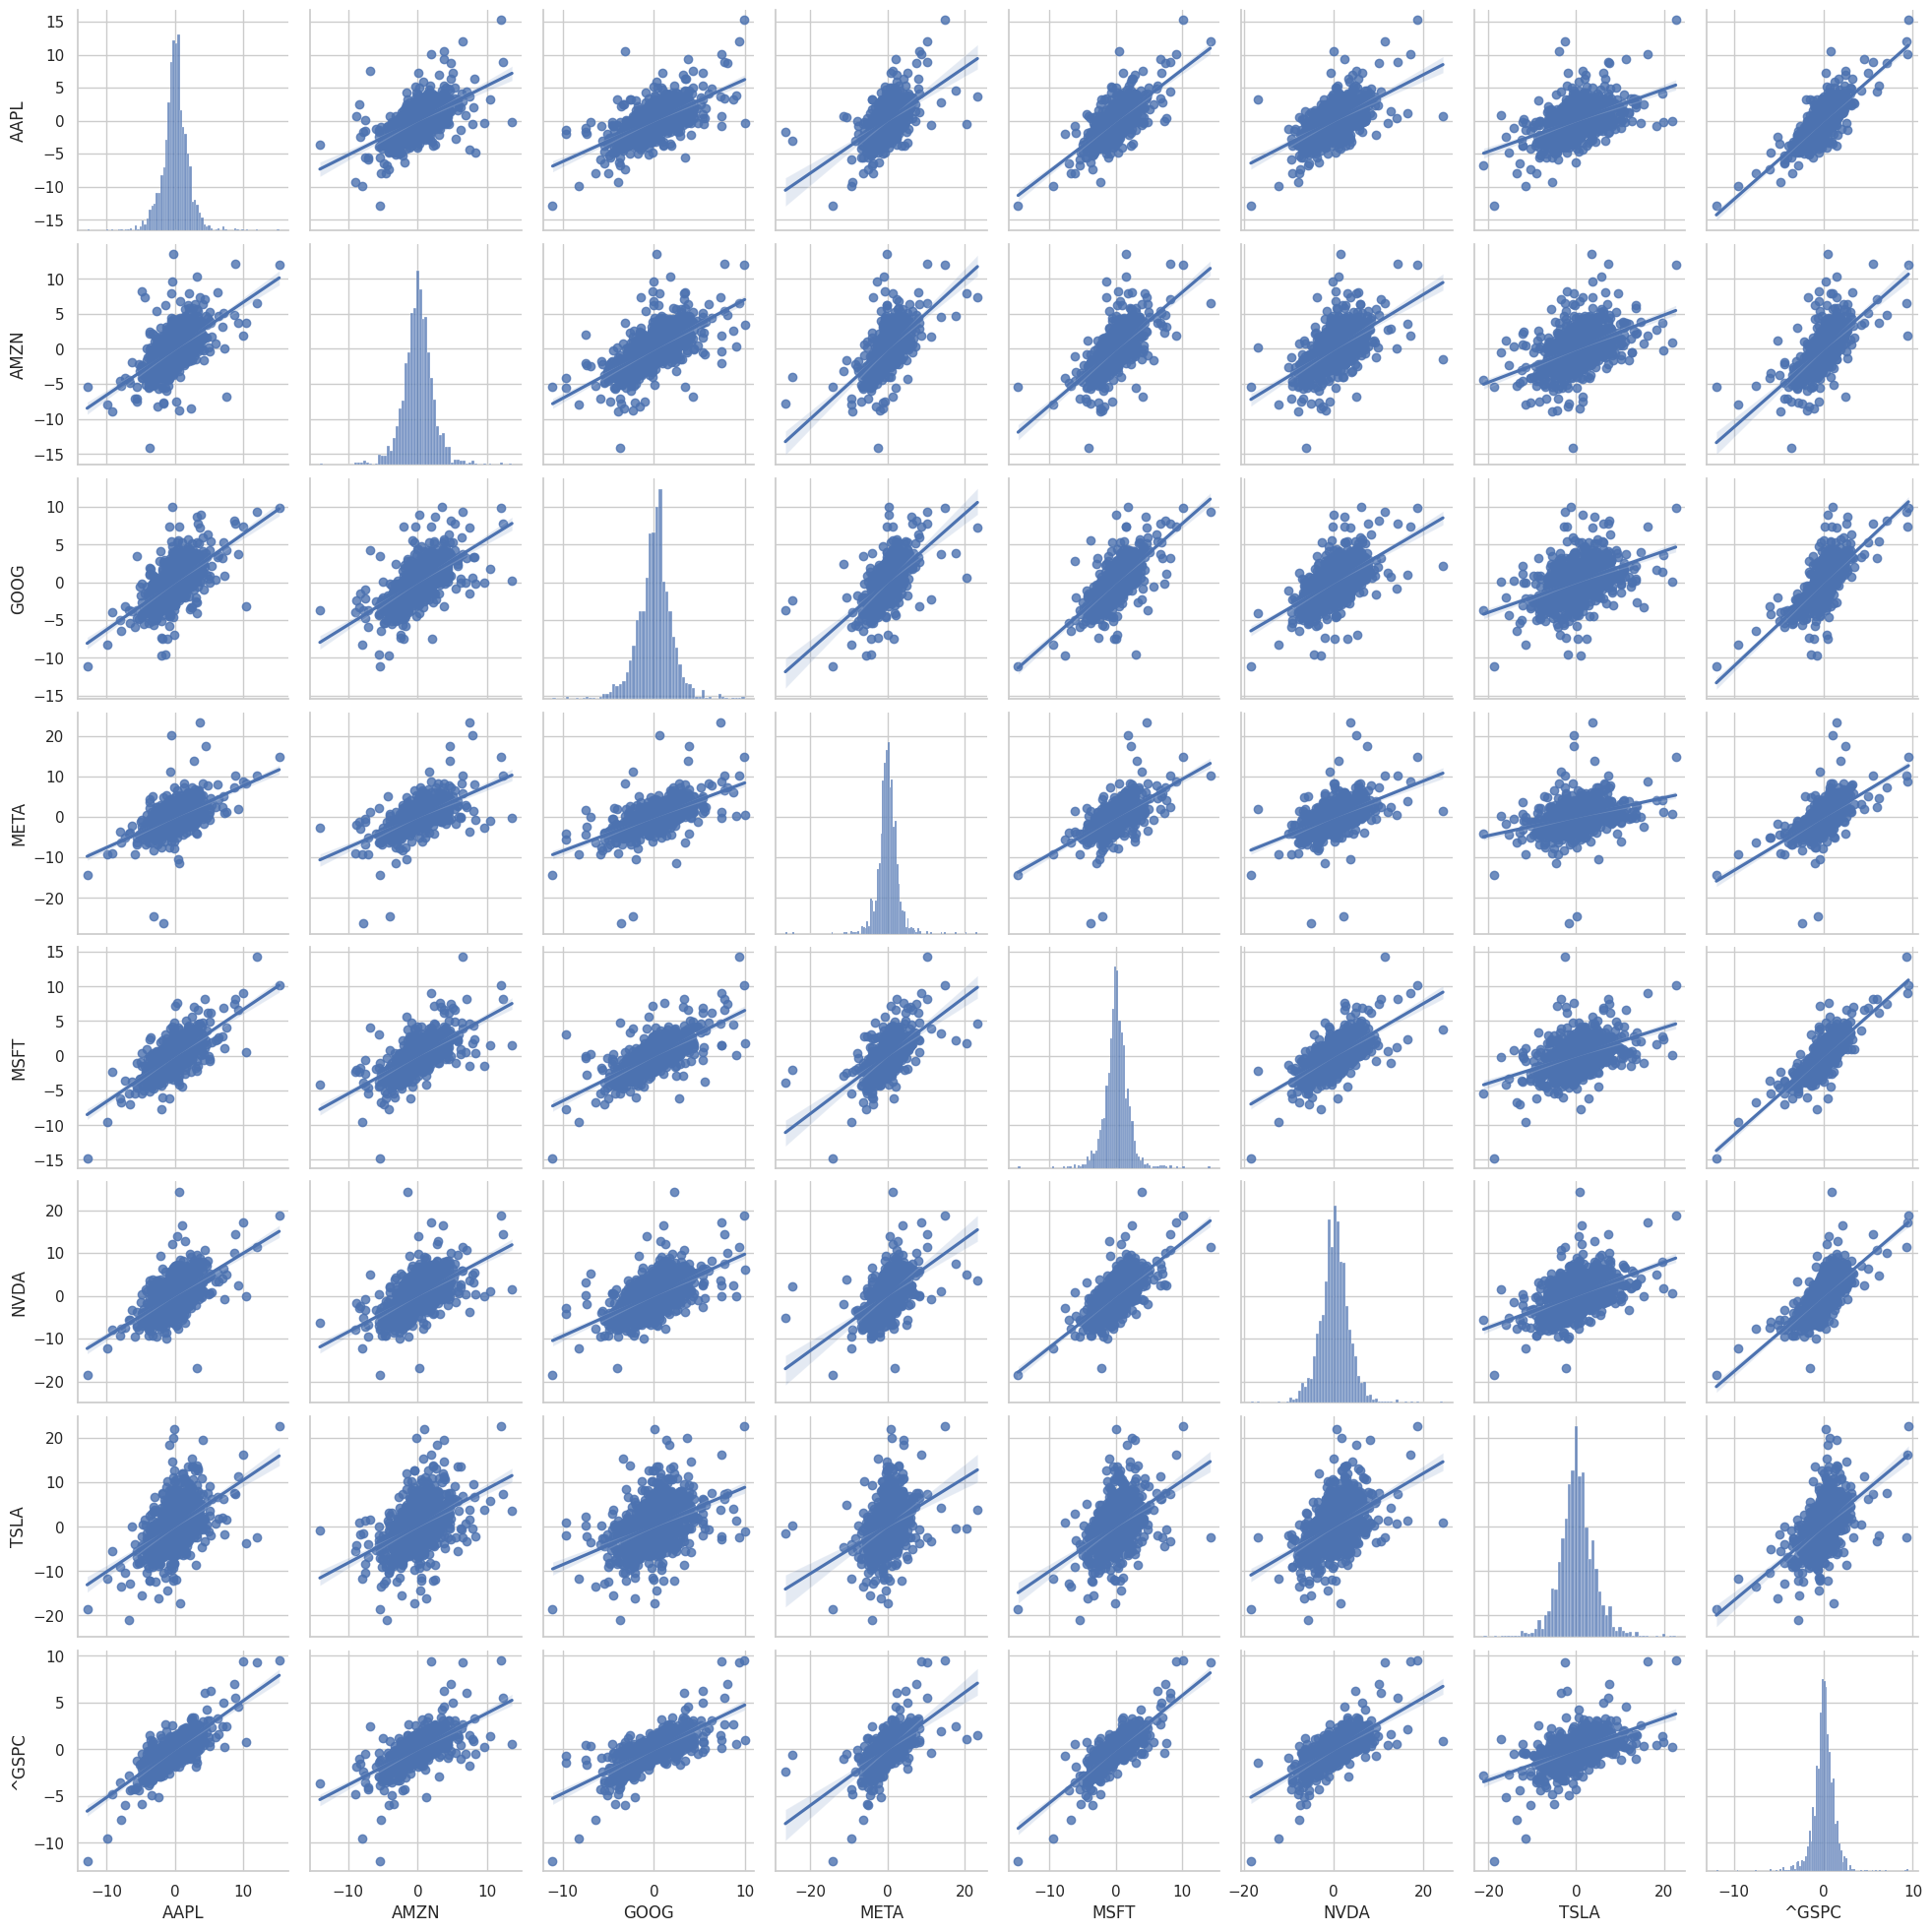

In [80]:
sns.pairplot(pivot_returns, kind='reg')

## PairGrid showing Scatter Plot of Daily Returns and Heatmap

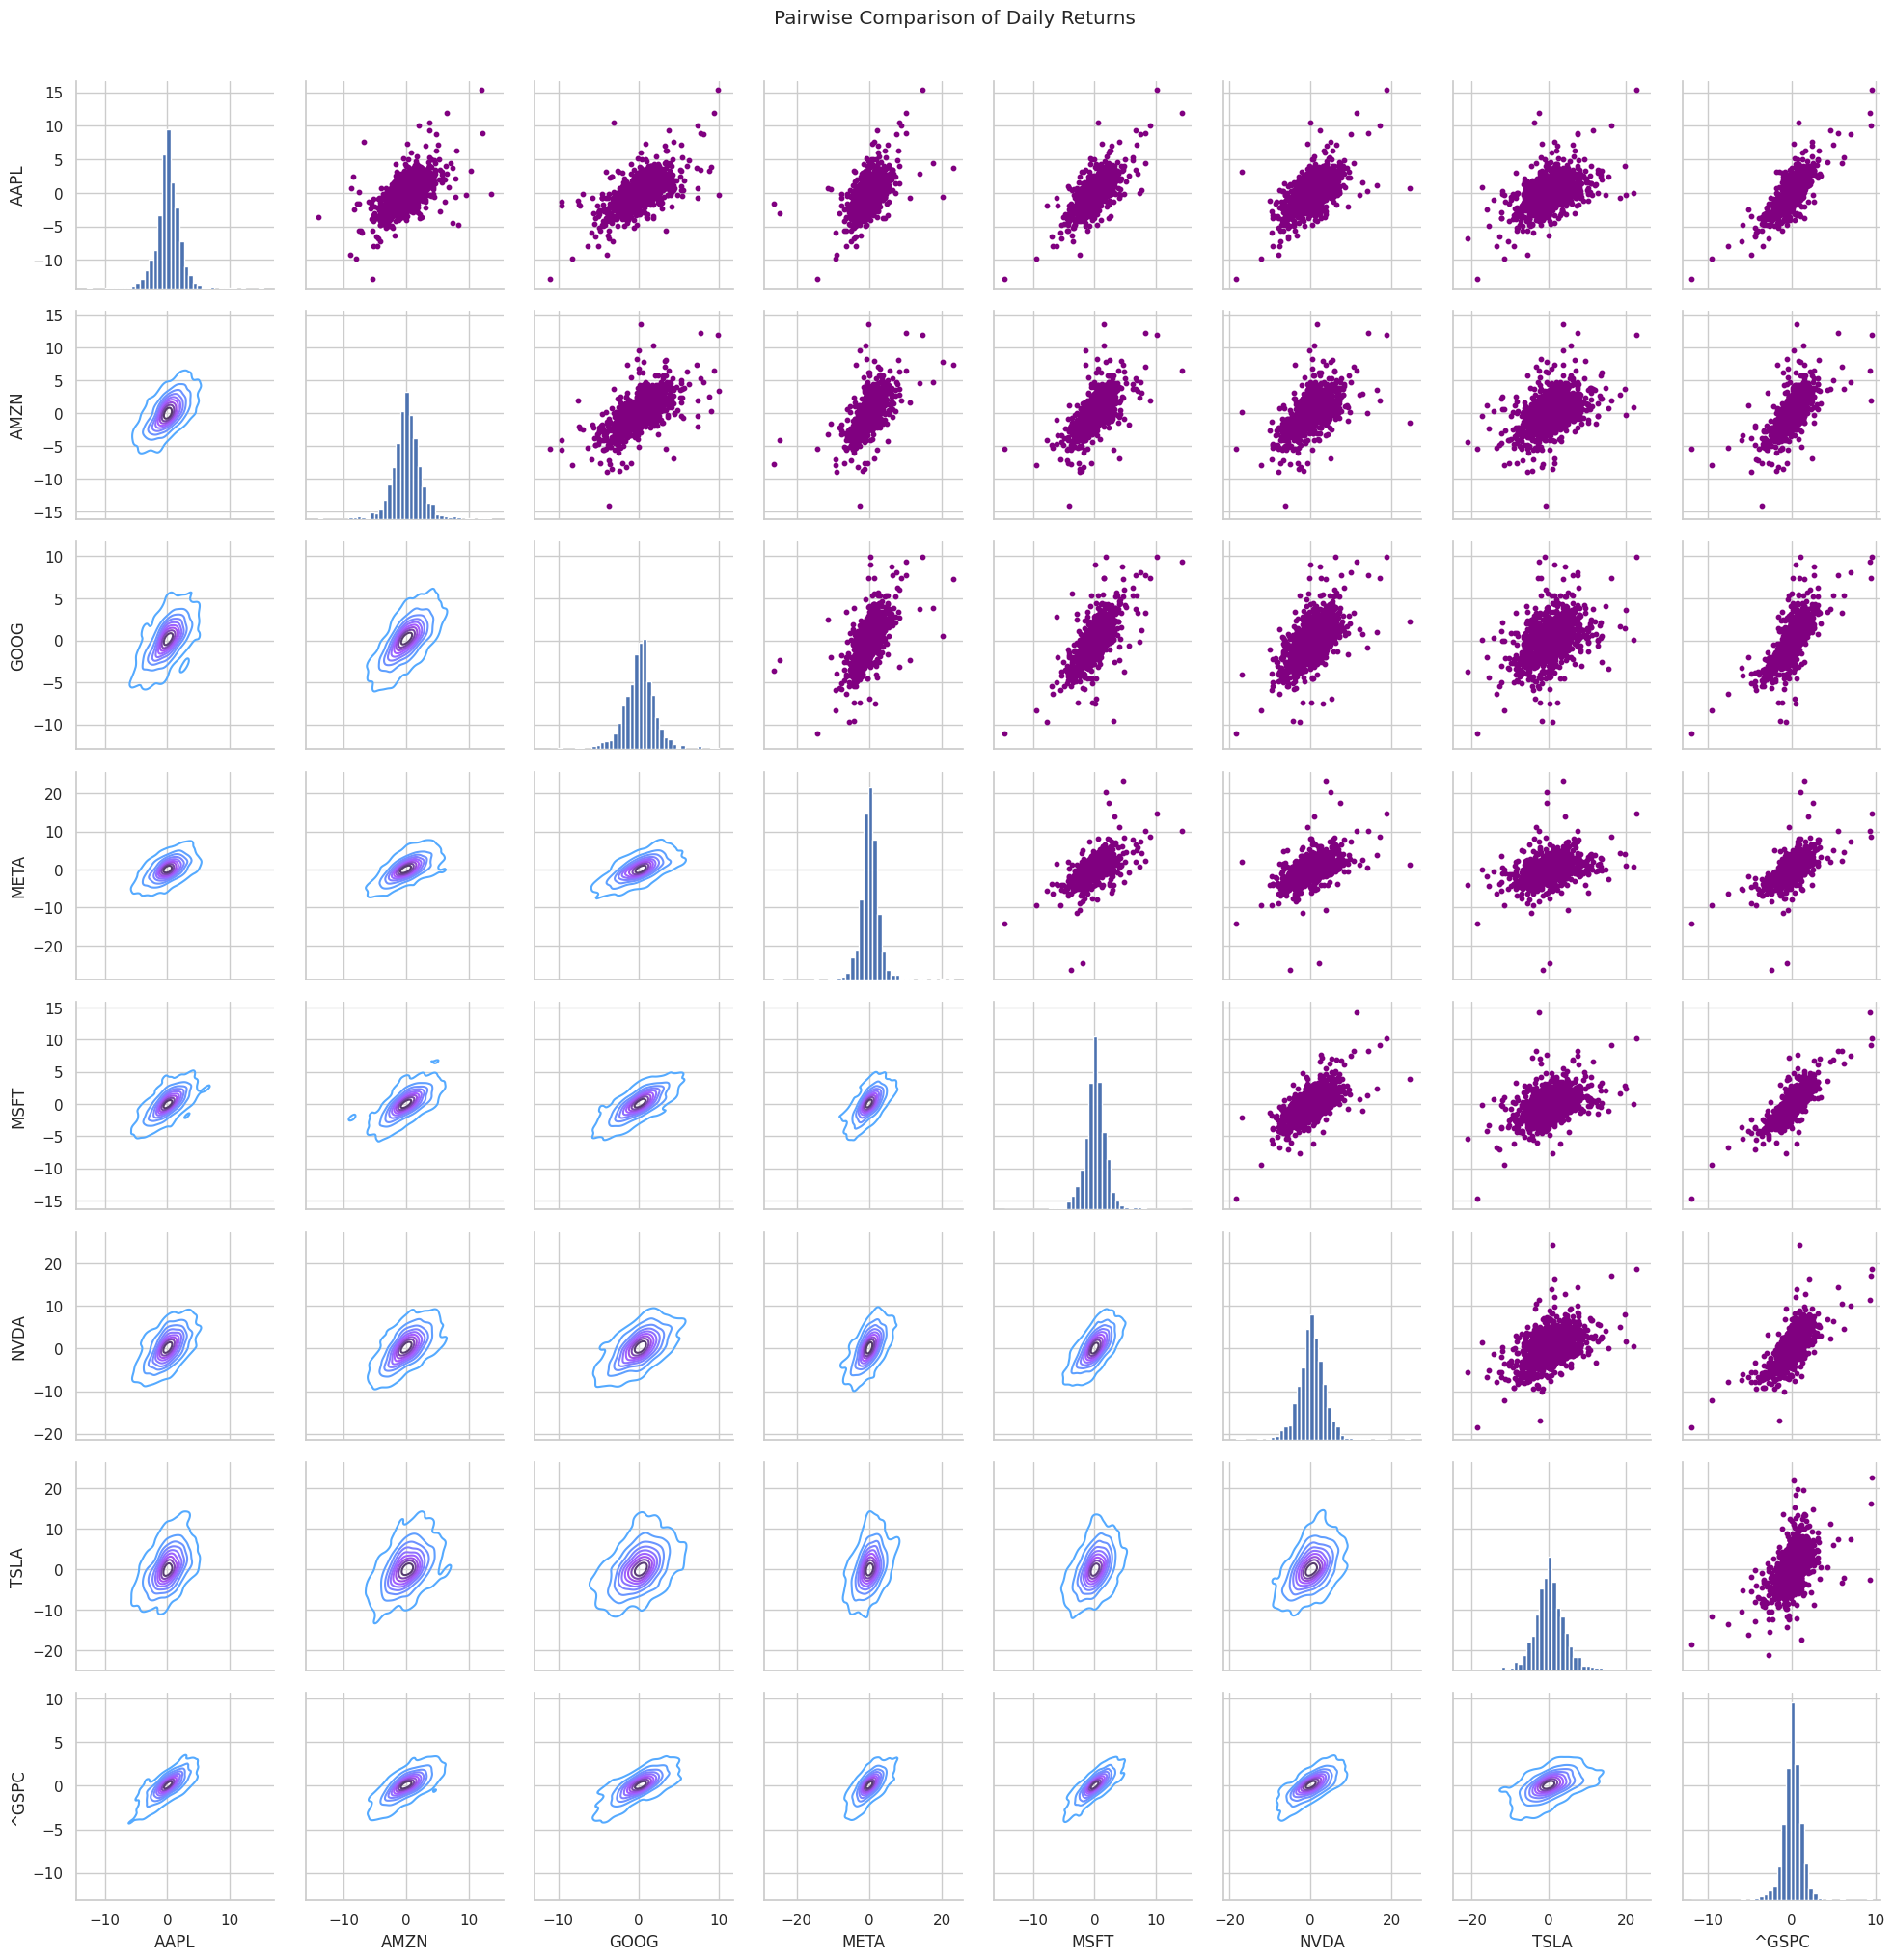

In [81]:
return_fig = sns.PairGrid(pivot_returns.dropna())

# Upper Traingle
return_fig.map_upper(plt.scatter, color='purple', s=10)
#Lower Traingle
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

plt.suptitle("Pairwise Comparison of Daily Returns", y=1.02)
return_fig.map_diag(plt.hist, bins=40)

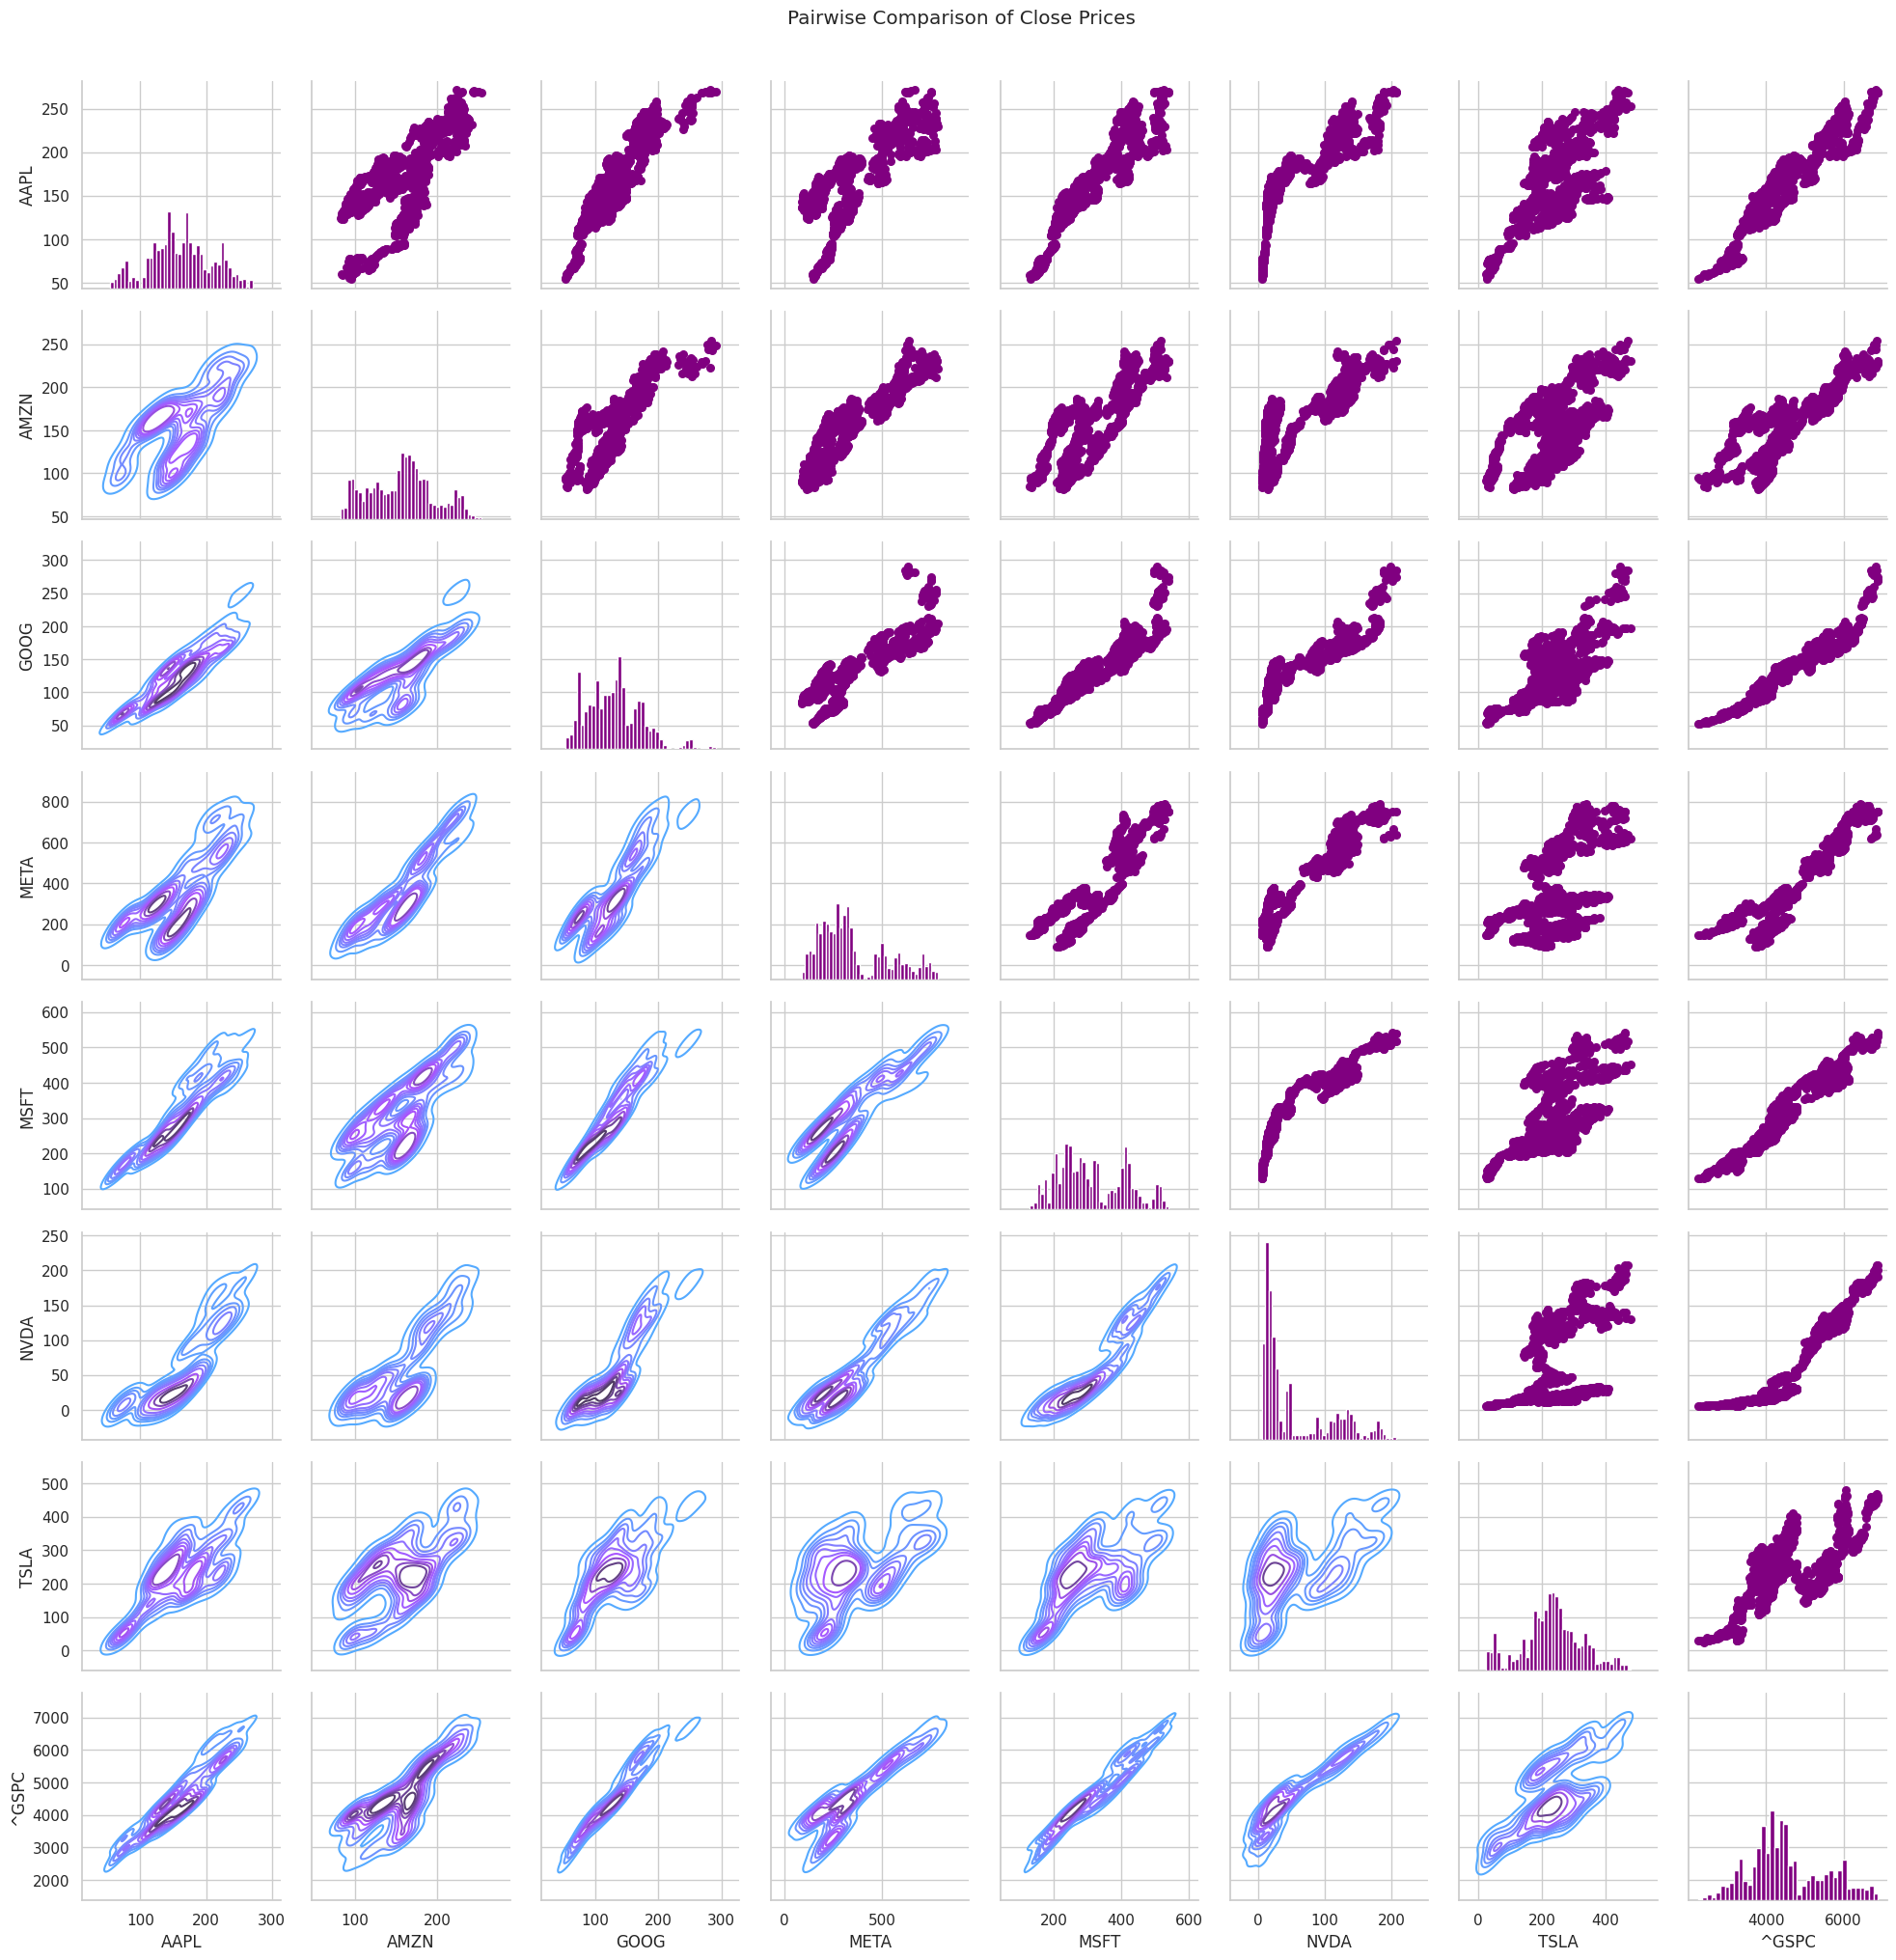

In [82]:
# Pivot combined_df so each ticker's Close price is a column
close_df = combined_df.pivot(index='Date', columns='Ticker', values='Close').dropna()

returns_fig = sns.PairGrid(close_df)

returns_fig.map_upper(plt.scatter, color='purple', s=30)

returns_fig.map_lower(sns.kdeplot, cmap='cool_d')

returns_fig.map_diag(plt.hist, bins=40, color='purple')

plt.suptitle("Pairwise Comparison of Close Prices", y=1.02)
plt.show()


## Are the Stocks Correlated

## Correlation Between Close Price and Trading Volume

In [ ]:
plt.figure(figsize=(20, 16))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, ticker in enumerate(tickers, 1):
    plt.subplot(4, 2, i)
    data = combined_df[combined_df["Ticker"] == ticker].copy()

    # Compute correlation
    corr = data[["Close", "Volume"]].corr().iloc[0, 1]

    # Scatter plot with regression line
    sns.regplot(x="Close", y="Volume", data=data, scatter_kws={"alpha":0.5}, line_kws={"color":"red"})
    plt.title(f"{ticker}: Close vs Volume\nCorrelation = {corr:.2f}")
    plt.xlabel("Close Price")
    plt.ylabel("Volume")

plt.tight_layout()
plt.show()


## Correlation Between Daily Return and Trading Volume

In [ ]:

returns_long = pivot_returns.stack().reset_index()
returns_long.columns = ['Date', 'Ticker', 'Daily_Return_%']

vol_df = combined_df[['Date', 'Ticker', 'Volume']].copy()

volume_returns_df = pd.merge(returns_long, vol_df, on=['Date', 'Ticker'], how='inner')

volume_returns_df['Daily_Return_%'] = pd.to_numeric(volume_returns_df['Daily_Return_%'], errors='coerce')
volume_returns_df['Volume'] = pd.to_numeric(volume_returns_df['Volume'], errors='coerce')
volume_returns_df = volume_returns_df.dropna(subset=['Daily_Return_%', 'Volume'])


In [ ]:
tickers = volume_returns_df['Ticker'].unique()

plt.figure(figsize=(20, 16))
plt.subplots_adjust(top=1.25, bottom=0.1)

for i, ticker in enumerate(tickers, 1):
    plt.subplot(4, 2, i)
    data = volume_returns_df[volume_returns_df['Ticker'] == ticker]

    # Compute correlation between daily % return and volume
    corr = data[['Daily_Return_%', 'Volume']].corr().iloc[0, 1]

    # Scatter plot with regression line
    sns.regplot(
        x='Daily_Return_%', y='Volume', data=data,
        scatter_kws={'alpha': 0.5, 's': 30},  # adjust size/opacity if needed
        line_kws={'color': 'red'}
    )
    plt.title(f"{ticker}: Daily Return (%) vs Volume\nCorrelation = {corr:.2f}")
    plt.xlabel("Daily Return (%)")
    plt.ylabel("Volume")

plt.tight_layout()
plt.show()


## Correlation Matrices

In [ ]:
corr_ret = pivot_returns.corr()
corr_close = close_df.corr()

# Create masks for upper triangles
mask_ret = np.triu(np.ones_like(corr_ret, dtype=bool))
mask_close = np.triu(np.ones_like(corr_close, dtype=bool))

plt.figure(figsize=(24, 20))

plt.subplot(2, 2, 1)
sns.heatmap(
    corr_ret, mask=mask_ret, annot=True, cmap='summer', fmt='.2f',
    square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}
)
plt.title('Correlation of Stock Return (Lower Triangle)')

plt.subplot(2, 2, 2)
sns.heatmap(
    corr_close, mask=mask_close, annot=True, cmap='summer', fmt='.2f',
    square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}
)
plt.title('Correlation of Stock Closing Price (Lower Triangle)')

plt.tight_layout()


## Risk Analysis

Using the daily expected return combined with standard deviation of daily return to visualise risk. 

In [ ]:
rets = pivot_returns.dropna()

area = np.pi*20

plt.figure(figsize=(12, 10))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

As expected, NVDA and TSLA are higher risk stocks. And S&P500 is lower risk.

## Training LSTM Model 

In [ ]:
# Kernel 1
df = combined_df

# Required columns: Date, Ticker, Close
req_cols = {"Date", "Ticker", "Close"}

# Parse dates and sort
df = df.copy()
df["Date"] = pd.to_datetime(df["Date"], utc=False) 
df = df.sort_values(["Ticker", "Date"])

# Keep only what we need
df_close = df[["Date", "Ticker", "Close"]].dropna()

# Wide format: one column per ticker = Close price
close_wide = df_close.pivot(index="Date", columns="Ticker", values="Close").sort_index()

m7 = ["AAPL", "MSFT", "AMZN", "GOOG", "META", "NVDA", "TSLA"]
target_ticker = "^GSPC"

available = [t for t in m7 + [target_ticker] if t in close_wide.columns]
missing_tickers = set(m7 + [target_ticker]) - set(available)
if missing_tickers:
    print(f"Warning: missing tickers in your data: {missing_tickers}")

data_wide = close_wide[available].copy()

# Ensure we have only dates where all inputs + target are present
data_wide = data_wide.dropna(how="any")

print("Shape (dates × tickers):", data_wide.shape)
display(data_wide.tail(5))


In [ ]:

# Kernel 2 - Lag 1 day feature

# Previous day's close for each Magnificent 7 ticker
X_all = data_wide[m7].shift(1)

# Same day's S&P 500 close
y_all = data_wide[target_ticker]

# Drop the first row (because of shift)
xy = pd.concat({"X": X_all, "y": y_all}, axis=1).dropna()
X_all = xy["X"]
y_all = xy["y"]

# Train/test split by calendar date boundary
split_date = pd.Timestamp("2025-01-01")  # train: < 2025-01-01, test: >= 2025-01-01
train_idx = X_all.index < split_date
test_idx  = X_all.index >= split_date

X_train, X_test = X_all.loc[train_idx], X_all.loc[test_idx]
y_train, y_test = y_all.loc[train_idx], y_all.loc[test_idx]

print("Train range:", X_train.index.min().date(), "→", X_train.index.max().date(), "n=", len(X_train))
print("Test  range:", X_test.index.min().date() if len(X_test) else None, 
      "→", X_test.index.max().date() if len(X_test) else None, "n=", len(X_test))

display(X_train.tail(3))
display(y_train.tail(3))


In [ ]:

# Kernel 3 - scale training data only - no leakage

from sklearn.preprocessing import MinMaxScaler

# Fit scalers on TRAIN ONLY
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = x_scaler.fit_transform(X_train.values)        # shape: (n_train, 7)
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))  # shape: (n_train, 1)

# Apply same scalers to test
X_test_scaled = x_scaler.transform(X_test.values)
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

# LSTM expects (samples, timesteps, features). Here timesteps=1 (previous night only).
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print("X_train_lstm:", X_train_lstm.shape, "| y_train:", y_train_scaled.shape)
print("X_test_lstm :", X_test_lstm.shape,  "| y_test :", y_test_scaled.shape)


In [ ]:

# Kernel 4 - Define LSTM Model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

n_features = X_train_lstm.shape[2]

model = keras.Sequential([
    layers.Input(shape=(1, n_features)),
    layers.LSTM(32, return_sequences=False),
    layers.Dense(16, activation="relu"),
    layers.Dense(1)  # predict next S&P500 close (scaled)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss="mse",
              metrics=["mae"])

model.summary()


In [ ]:

# Kernel 5 - Train LSTM

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
]

history = model.fit(
    X_train_lstm, y_train_scaled,
    validation_split=0.1,      # last 10% of train as validation (Keras keeps order if shuffle=False)
    epochs=300,
    batch_size=32,
    shuffle=False,              # IMPORTANT for time series
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="train MSE")
plt.plot(history.history["val_loss"], label="val MSE")
plt.title("Training history")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

# Kernel 6 —  Predict

# Predictions on TEST (scaled)
y_pred_test_scaled  = model.predict(X_test_lstm)

# Back to original price scale
y_pred_test  = y_scaler.inverse_transform(y_pred_test_scaled).ravel()

# Build prediction series aligned to TEST dates
pred_test  = pd.Series(y_pred_test, index=y_test.index, name="Predicted")

# For convenience, also slice the actual S&P to the test window
actual_test = y_test.copy()
actual_test.name = "Actual"

# Quick check
display(pd.concat([actual_test, pred_test], axis=1).head())
display(pd.concat([actual_test, pred_test], axis=1).tail())


In [ ]:

# Kernel 7 - Plotting

plt.figure(figsize=(12,6))

# Plot full actual S&P 500 close series
plt.plot(y_all.index, y_all.values,
         label="S&P 500 Actual (Full)", color="black", linewidth=1.8)

# Overlay predicted values for test period only
plt.plot(pred_test.index, pred_test.values,
         label="LSTM Predicted (Test)", color="#d62728", alpha=0.9)

plt.title("S&P 500 Close — Actual vs LSTM Prediction")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:

plt.figure(figsize=(12,6))
plt.plot(actual_test.index, actual_test.values,
         label="S&P 500 Actual (Test)", color="black", linewidth=1.8)
plt.plot(pred_test.index, pred_test.values,
         label="LSTM Predicted (Test)", color="#d62728", alpha=0.9)

plt.title("S&P 500 Close — Actual vs LSTM Prediction (Test Period Only)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Kernel 8 - Test Metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error

if len(y_test) > 0:
    mae  = mean_absolute_error(y_test.values, pred_test.values)
    rmse = mean_squared_error(y_test.values, pred_test.values, squared=False)
    mape = (np.abs((y_test.values - pred_test.values) / y_test.values).mean()) * 100

    print(f"Test MAE : {mae:,.4f}")
    print(f"Test RMSE: {rmse:,.4f}")
    print(f"Test MAPE: {mape:,.2f}%")
else:
    print("No test period found at or after 2025-01-01.")


## SHAP Analysis

In [ ]:

# Import SHAP and Quieter TensorFlow logs

import shap
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # quieter TF logs


# Make plots aesthetic
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

feature_cols = list(m7)

print("shap version:", shap.__version__)


In [ ]:

# Robust prediction wrapper

def ensure_feature_order(X, feature_cols):
    """
    Accepts a DataFrame or NumPy array and returns a 2D NumPy array
    in the exact order specified by feature_cols.
    """
    if isinstance(X, pd.DataFrame):
        missing = [c for c in feature_cols if c not in X.columns]
        if missing:
            raise ValueError(f"Missing required feature columns: {missing}")
        X_ordered = X.reindex(columns=feature_cols)
        return X_ordered.values
    elif isinstance(X, np.ndarray):
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        if X.shape[1] != len(feature_cols):
            raise ValueError(
                f"Expected {len(feature_cols)} features in order {feature_cols}, got {X.shape}."
            )
        return X
    else:
        raise TypeError(f"Unsupported type for ensure_feature_order: {type(X)}")

def transform_for_model(X_any):
    """
    Returns features scaled and reshaped for the LSTM:
    shape -> (n_samples, 1, n_features)
    """
    X_np = ensure_feature_order(X_any, feature_cols)   # (n, 7)
    X_scaled = x_scaler.transform(X_np)                # (n, 7)
    X_lstm   = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
    return X_lstm

def predict_from_original(X_any):
    """
    Robust predictor for SHAP:
    - Enforces feature order
    - Scales with training-fitted x_scaler
    - Reshapes to (n, 1, n_features)
    - Predicts with the trained LSTM
    - Returns predictions in ORIGINAL price units via y_scaler.inverse_transform
    """
    X_lstm = transform_for_model(X_any)
    y_pred_scaled = model.predict(X_lstm, verbose=0).ravel()        
    # Inverse-scale to original price units for interpretability
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    return y_pred

# Fail-fast checks
_ = ensure_feature_order(X_train, feature_cols)
_ = ensure_feature_order(X_test,  feature_cols)
print("Feature order integrity checks passed.")


In [ ]:

# Train & Test Selection

# Keep background modest for speed; increase for final figures
bg_size = min(200, len(X_train))
background = X_train.loc[:, feature_cols].sample(n=bg_size, random_state=42)

# Evaluation set: first N test rows (unscaled, original units)
eval_size = min(300, len(X_test))   # adjust as needed
X_eval = X_test.loc[:, feature_cols].iloc[:eval_size]

print("Background shape:", background.shape)
print("Eval (test) shape:", X_eval.shape)


In [ ]:
# Build KernelExplainer and compute SHAP values

explainer = shap.KernelExplainer(
    model=predict_from_original,   # robust wrapper
    data=background.values,       # Wrapper hadles numpy array
    link="identity"
)

shap_values = explainer.shap_values(X_eval.values, nsamples="auto")

# Normalize to array for single-output regression
if isinstance(shap_values, list):
    shap_values = shap_values[0]

print("SHAP values shape:", shap_values.shape)  # expected: (n_eval, 7)


In [ ]:
# Summary Bar & Beeswarm

# Bar: mean |SHAP| across eval set
shap.summary_plot(
    shap_values=shap_values,
    features=X_eval[feature_cols],
    feature_names=feature_cols,
    plot_type="bar",
    show=True
)

# Beeswarm: distribution & direction of contribution
shap.summary_plot(
    shap_values=shap_values,
    features=X_eval[feature_cols],
    feature_names=feature_cols,
    show=True
)

In [ ]:

# Dependance Plots

import os
save_figs = True
out_dir = "shap_dependence_plots"
if save_figs:
    os.makedirs(out_dir, exist_ok=True)

interaction = "auto"  # color by strongest interaction; or set a specific feature name

for feat in feature_cols:
    shap.dependence_plot(
        ind=feat,
        shap_values=shap_values,
        features=X_eval[feature_cols],
        feature_names=feature_cols,
        interaction_index=interaction,
        show=False
    )
    plt.title(f"SHAP Dependence — {feat} (interaction={interaction})")
    if save_figs:
        plt.savefig(os.path.join(out_dir, f"dependence_{feat}.png"), dpi=150, bbox_inches="tight")
    plt.show()


In [ ]:

# Local explanation for a single test instance

# Pick an index within [0, len(X_eval)-1]
i = -1  # last eval row; change as needed

row_x = X_eval.iloc[i]
row_shap = shap_values[i]

# Extract the explainer's expected value safely
base_value = explainer.expected_value
if isinstance(base_value, (list, np.ndarray)):
    base_value = base_value[0]

# Build a SHAP Explanation (works across modern APIs)
explanation = shap.Explanation(
    values=row_shap,            # SHAP values for this row (shape: n_features,)
    base_values=base_value,     # model baseline
    data=row_x.values,          # original feature values
    feature_names=feature_cols
)

# 1) Waterfall plot (static, recommended for coursework PDF)
shap.plots.waterfall(explanation, max_display=10, show=True)

# 2) Force plot
# Try the new API first; if not available, use legacy shap.force_plot.
try:
    # New API (matplotlib=False produces an interactive JS plot in notebooks)
    shap.plots.force(explanation)
except Exception as e:
    # Legacy fallback (works with older SHAP; may render JS)
    shap.force_plot(
        base_value=base_value,
        shap_values=row_shap,
        features=row_x.values,
        feature_names=feature_cols
    )



In [ ]:
# Numeric importances table

mean_abs = np.abs(shap_values).mean(axis=0)
importance = pd.DataFrame({"feature": feature_cols, "mean_abs_shap": mean_abs}) \
              .sort_values("mean_abs_shap", ascending=False) \
              .reset_index(drop=True)

display(importance)

In [ ]:
# Integrity Report

# Scaler vectors should match feature count
for attr in ["min_", "scale_", "data_min_", "data_max_"]:
    arr = getattr(x_scaler, attr, None)
    if arr is not None:
        assert arr.shape[0] == len(feature_cols), f"Scaler attr {attr} misaligned: {arr.shape}"

# Wrapper should accept both DataFrame and array
_ = predict_from_original(background.head(3))
_ = predict_from_original(background.head(3).values)
print("Integrity OK: scaler size, feature order, wrapper I/O.")


## Retraining LSTM with UL Stock Price Close

The theory here is that the UL stock close should have little impact on the model - given that UL is a UK based stock in the FTSE100, not in the S&P500. 

This will just be a matter of retraining the LSTM on all_stocks df instead of combined_df

In [ ]:
all_stocks

In [ ]:
# Kernel 1
# Required columns: Date, Ticker, Close
req_cols = {"Date", "Ticker", "Close"}
missing = req_cols - set(all_stocks.columns)
if missing:
    raise ValueError(f"Your all_stocks df is missing required columns: {missing}")

# Parse dates and sort
df = all_stocks.copy()
df["Date"] = pd.to_datetime(df["Date"], utc=False)
df = df.sort_values(["Ticker", "Date"])

# Keep only what we need and pivot to wide matrix
df_close = df[["Date", "Ticker", "Close"]].dropna()
close_wide = df_close.pivot(index="Date", columns="Ticker", values="Close").sort_index()

# Define tickers
m7 = ["AAPL", "MSFT", "AMZN", "GOOG", "META", "NVDA", "TSLA"]
extra_feature = "UL"            # Unilever ADR (not in S&P 500)
target_ticker = "^GSPC"

# Features now include UL
features = m7 + [extra_feature]

# Check availability in your data
available = [t for t in features + [target_ticker] if t in close_wide.columns]
missing_tickers = set(features + [target_ticker]) - set(available)
if missing_tickers:
    print(f"Warning: missing tickers in your data: {missing_tickers}")

# Build working wide frame and drop rows with any missing feature/target
data_wide = close_wide[available].copy().dropna(how="any")

print("Shape (dates × tickers):", data_wide.shape)
display(data_wide.tail(5))


In [ ]:

# Kernel 2

# Features: previous day's close for all selected features (M7 + UL)
X_all = data_wide[features].shift(1)

# Target: same day's S&P 500 close
y_all = data_wide[target_ticker]

# Drop the first row (because of shift)
xy = pd.concat({"X": X_all, "y": y_all}, axis=1).dropna()
X_all = xy["X"]
y_all = xy["y"]

# Train/test split by calendar boundary
split_date = pd.Timestamp("2025-01-01")
train_idx = X_all.index < split_date
test_idx  = X_all.index >= split_date

X_train, X_test = X_all.loc[train_idx], X_all.loc[test_idx]
y_train, y_test = y_all.loc[train_idx], y_all.loc[test_idx]

print("Train range:", X_train.index.min().date(), "→", X_train.index.max().date(), "n=", len(X_train))
print("Test  range:", (X_test.index.min().date() if len(X_test) else None), 
      "→", (X_test.index.max().date() if len(X_test) else None), "n=", len(X_test))

display(X_train.tail(3))
display(y_train.tail(3))


In [ ]:

# Kernel 3

# Lock feature order for the scaler and for all downstream code
feature_cols = list(features)  # ["AAPL","MSFT","AMZN","GOOGL","META","NVDA","TSLA","UL"]

# Fit scalers on TRAIN ONLY (no leakage)
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = x_scaler.fit_transform(X_train.loc[:, feature_cols].values)   # (n_train, 8)
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))         # (n_train, 1)

# Apply same scalers to TEST
X_test_scaled = x_scaler.transform(X_test.loc[:, feature_cols].values)         # (n_test, 8)
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))               # (n_test, 1)

# LSTM expects (samples, timesteps, features). timesteps=1 (previous night only).
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print("X_train_lstm:", X_train_lstm.shape, "| y_train:", y_train_scaled.shape)
print("X_test_lstm :", X_test_lstm.shape,  "| y_test :", y_test_scaled.shape)


In [ ]:
# Kernel 4 - Define LSTM Model

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

n_features = X_train_lstm.shape[2]

model = keras.Sequential([
    layers.Input(shape=(1, n_features)),
    layers.LSTM(32, return_sequences=False),
    layers.Dense(16, activation="relu"),
    layers.Dense(1)  # predict next S&P500 close (scaled)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss="mse",
              metrics=["mae"])

model.summary()

In [ ]:
# Kernel 5 - Train LSTM

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
]

history = model.fit(
    X_train_lstm, y_train_scaled,
    validation_split=0.1,      # last 10% of train as validation (Keras keeps order if shuffle=False)
    epochs=300,
    batch_size=32,
    shuffle=False,              # IMPORTANT for time series
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="train MSE")
plt.plot(history.history["val_loss"], label="val MSE")
plt.title("Training history")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Kernel 6 —  Predict

# Predictions on TEST (scaled)
y_pred_test_scaled  = model.predict(X_test_lstm)

# Back to original price scale
y_pred_test  = y_scaler.inverse_transform(y_pred_test_scaled).ravel()

# Build prediction series aligned to TEST dates
pred_test  = pd.Series(y_pred_test, index=y_test.index, name="Predicted")

# For convenience, also slice the actual S&P to the test window
actual_test = y_test.copy()
actual_test.name = "Actual"

# Quick check
display(pd.concat([actual_test, pred_test], axis=1).head())
display(pd.concat([actual_test, pred_test], axis=1).tail())


In [ ]:
# Kernel 7 - Plotting

plt.figure(figsize=(12,6))

# Plot full actual S&P 500 close series
plt.plot(y_all.index, y_all.values,
         label="S&P 500 Actual (Full)", color="black", linewidth=1.8)

# Overlay predicted values for test period only
plt.plot(pred_test.index, pred_test.values,
         label="LSTM Predicted (Test)", color="#d62728", alpha=0.9)

plt.title("S&P 500 Close — Actual vs LSTM Prediction")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(12,6))
plt.plot(actual_test.index, actual_test.values,
         label="S&P 500 Actual (Test)", color="black", linewidth=1.8)
plt.plot(pred_test.index, pred_test.values,
         label="LSTM Predicted (Test)", color="#d62728", alpha=0.9)

plt.title("S&P 500 Close — Actual vs LSTM Prediction (Test Period Only)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Kernel 8 - Test Metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error

if len(y_test) > 0:
    mae  = mean_absolute_error(y_test.values, pred_test.values)
    rmse = mean_squared_error(y_test.values, pred_test.values, squared=False)
    mape = (np.abs((y_test.values - pred_test.values) / y_test.values).mean()) * 100

    print(f"Test MAE : {mae:,.4f}")
    print(f"Test RMSE: {rmse:,.4f}")
    print(f"Test MAPE: {mape:,.2f}%")
else:
    print("No test period found at or after 2025-01-01.")

## SHAP Analysis 

In [ ]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

print("Feature columns for SHAP:", feature_cols)


In [ ]:
def ensure_feature_order(X, feature_cols):
    import numpy as np, pandas as pd
    if isinstance(X, pd.DataFrame):
        missing = [c for c in feature_cols if c not in X.columns]
        if missing:
            raise ValueError(f"Missing required feature columns: {missing}")
        return X.reindex(columns=feature_cols).values
    else:
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        if X.shape[1] != len(feature_cols):
            raise ValueError(
                f"Expected {len(feature_cols)} features in order {feature_cols}, got {X.shape}."
            )
        return X

def transform_for_model(X_any):
    X_np = ensure_feature_order(X_any, feature_cols)   # now 8 features
    X_scaled = x_scaler.transform(X_np)
    X_lstm   = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
    return X_lstm

def predict_from_original(X_any):
    X_lstm = transform_for_model(X_any)
    y_pred_scaled = model.predict(X_lstm, verbose=0).ravel()
    # Return predictions in original price units for interpretability
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    return y_pred

# integrity check
_ = ensure_feature_order(X_train, feature_cols)
_ = ensure_feature_order(X_test,  feature_cols)
print("SHAP: feature order integrity OK.")


In [ ]:
_size = min(200, len(X_train))
background = X_train.loc[:, feature_cols].sample(n=bg_size, random_state=42)

eval_size = min(300, len(X_test))
X_eval = X_test.loc[:, feature_cols].iloc[:eval_size]

print("Background shape:", background.shape)
print("Eval (test) shape:", X_eval.shape)


In [ ]:
explainer = shap.KernelExplainer(
    model=predict_from_original,
    data=background.values,
    link="identity"
)

shap_values = explainer.shap_values(X_eval.values, nsamples="auto")
if isinstance(shap_values, list):
    shap_values = shap_values[0]

print("SHAP values shape:", shap_values.shape)  # (n_eval, 8) expected (M7 + UL)


In [ ]:
# Summary Bar & Beeswarm

# Bar: mean |SHAP| across eval set
shap.summary_plot(
    shap_values=shap_values,
    features=X_eval[feature_cols],
    feature_names=feature_cols,
    plot_type="bar",
    show=True
)

# Beeswarm: distribution & direction of contribution
shap.summary_plot(
    shap_values=shap_values,
    features=X_eval[feature_cols],
    feature_names=feature_cols,
    show=True
)

In [ ]:
# Dependance Plots

import os
save_figs = True
out_dir = "shap_dependence_plots"
if save_figs:
    os.makedirs(out_dir, exist_ok=True)

interaction = "auto"  # color by strongest interaction; or set a specific feature name

for feat in feature_cols:
    shap.dependence_plot(
        ind=feat,
        shap_values=shap_values,
        features=X_eval[feature_cols],
        feature_names=feature_cols,
        interaction_index=interaction,
        show=False
    )
    plt.title(f"SHAP Dependence — {feat} (interaction={interaction})")
    if save_figs:
        plt.savefig(os.path.join(out_dir, f"dependence_{feat}.png"), dpi=150, bbox_inches="tight")
    plt.show()

In [ ]:
# Local explanation for a single test instance

# Pick an index within [0, len(X_eval)-1]
i = -1  # last eval row; change as needed

row_x = X_eval.iloc[i]
row_shap = shap_values[i]

# Extract the explainer's expected value safely
base_value = explainer.expected_value
if isinstance(base_value, (list, np.ndarray)):
    base_value = base_value[0]

# Build a SHAP Explanation (works across modern APIs)
explanation = shap.Explanation(
    values=row_shap,            # SHAP values for this row (shape: n_features,)
    base_values=base_value,     # model baseline
    data=row_x.values,          # original feature values
    feature_names=feature_cols
)

# 1) Waterfall plot (static, recommended for coursework PDF)
shap.plots.waterfall(explanation, max_display=10, show=True)

# 2) Force plot
# Try the new API first; if not available, use legacy shap.force_plot.
try:
    # New API (matplotlib=False produces an interactive JS plot in notebooks)
    shap.plots.force(explanation)
except Exception as e:
    # Legacy fallback (works with older SHAP; may render JS)
    shap.force_plot(
        base_value=base_value,
        shap_values=row_shap,
        features=row_x.values,
        feature_names=feature_cols
    )

In [ ]:
# Numeric importances table

mean_abs = np.abs(shap_values).mean(axis=0)
importance = pd.DataFrame({"feature": feature_cols, "mean_abs_shap": mean_abs}) \
              .sort_values("mean_abs_shap", ascending=False) \
              .reset_index(drop=True)

display(importance)

In [ ]:
# Rank UL Importance

rank = importance.index[importance["feature"] == "UL"].tolist()
if rank:
    print(f"UL global importance rank (0=highest): {rank[0]}")
else:
    print("UL not found in importance table (check feature naming).")


UL ranks low in importance as expected. 

## Training LSTM on M7 Close Prices and Volumes

In [ ]:
# Kernel V1 — volume-only features + target

source_df = all_stocks  

req_cols = {"Date", "Ticker", "Close", "Volume"}
missing = req_cols - set(source_df.columns)
if missing:
    raise ValueError(f"Your DataFrame is missing required columns: {missing}")

# Parse dates, sort
source_df = source_df.copy()
source_df["Date"] = pd.to_datetime(source_df["Date"], utc=False)
source_df = source_df.sort_values(["Ticker", "Date"])

# Magnificent 7 & target
m7 = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "NVDA", "TSLA"]
target_ticker = "^GSPC"

# Wide pivots
close_wide  = source_df.pivot(index="Date", columns="Ticker", values="Close").sort_index()
volume_wide = source_df.pivot(index="Date", columns="Ticker", values="Volume").sort_index()

# Check availability
available_m7 = [t for t in m7 if t in volume_wide.columns]
if len(available_m7) < len(m7):
    print("Warning: missing M7 tickers in Volume:", set(m7) - set(available_m7))
if target_ticker not in close_wide.columns:
    raise ValueError("Target ^GSPC close not found in data.")

# Features: M7 volumes only (rename with suffix for clarity)
features_wide = volume_wide[available_m7].copy()
features_wide.columns = [f"{t}_Volume" for t in available_m7]

# Target: S&P 500 close
sp500 = close_wide[target_ticker].rename("SP500_Close")

# Merge & drop NaNs (ensure overlapping date index)
data_all = pd.concat([features_wide, sp500], axis=1).dropna(how="any").sort_index()

print("Features shape:", features_wide.shape)
print("Merged (features + target) shape:", data_all.shape)
display(data_all.tail(3))


In [ ]:
# Kernel V2 — lag-1 features + time-based split

feature_cols = [c for c in data_all.columns if c != "SP500_Close"]

# Previous trading day volumes → predict same-day SP500 close
X_all = data_all[feature_cols].shift(1)
y_all = data_all["SP500_Close"]

xy = pd.concat({"X": X_all, "y": y_all}, axis=1).dropna()
X_all, y_all = xy["X"], xy["y"]

split_date = pd.Timestamp("2025-01-01")
train_idx = X_all.index < split_date
test_idx  = X_all.index >= split_date

X_train, X_test = X_all.loc[train_idx], X_all.loc[test_idx]
y_train, y_test = y_all.loc[train_idx], y_all.loc[test_idx]

print("n_features:", X_train.shape[1])
print("Train:", X_train.index.min().date(), "→", X_train.index.max().date(), "| n=", len(X_train))
print("Test :", (X_test.index.min().date() if len(X_test) else None), "→",
      (X_test.index.max().date() if len(X_test) else None), "| n=", len(X_test))

In [ ]:
# Kernel V3 — scale + reshape (timesteps=1)

from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler((0, 1))
y_scaler = MinMaxScaler((0, 1))

X_train_scaled = x_scaler.fit_transform(X_train.values)
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

X_test_scaled  = x_scaler.transform(X_test.values)
y_test_scaled  = y_scaler.transform(y_test.values.reshape(-1, 1))

# LSTM expects (samples, timesteps, features); here timesteps=1
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print("X_train_lstm:", X_train_lstm.shape, "| y_train_scaled:", y_train_scaled.shape)
print("X_test_lstm :", X_test_lstm.shape,  "| y_test_scaled :", y_test_scaled.shape)

In [ ]:
# Kernel V4 — Build LSTM

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # force CPU to avoid GPU init logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"   # quiet TF logs
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

n_features = X_train_lstm.shape[2]

model = keras.Sequential([
    layers.Input(shape=(1, n_features)),
    layers.LSTM(64, return_sequences=False),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss="mse",
              metrics=["mae"])

model.summary()

In [ ]:
# Kernel V5 — training

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
]

history = model.fit(
    X_train_lstm, y_train_scaled,
    validation_split=0.1,
    epochs=300,
    batch_size=32,
    shuffle=False,
    callbacks=callbacks,
    verbose=1
)

# Optional quick look at the training curves
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="train MSE")
plt.plot(history.history["val_loss"], label="val MSE")
plt.title("Training history (volumes-only LSTM)")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
# Kernel V6 — predictions on TEST only

y_pred_test_scaled = model.predict(X_test_lstm, verbose=0)
y_pred_test = y_scaler.inverse_transform(y_pred_test_scaled).ravel()

pred_test  = pd.Series(y_pred_test, index=y_test.index, name="Predicted")
actual_test = y_test.copy(); actual_test.name = "Actual"

display(pd.concat([actual_test, pred_test], axis=1).head())
display(pd.concat([actual_test, pred_test], axis=1).tail())

## SHAP Analysis

In [ ]:
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

def ensure_feature_order(X, feature_cols):
    import numpy as np, pandas as pd
    if isinstance(X, pd.DataFrame):
        missing = [c for c in feature_cols if c not in X.columns]
        if missing:
            raise ValueError(f"Missing required feature columns: {missing}")
        return X.reindex(columns=feature_cols).values
    X = np.asarray(X)
    if X.ndim == 1:
        X = X.reshape(1, -1)
    if X.shape[1] != len(feature_cols):
        raise ValueError(f"Expected {len(feature_cols)} features in order {feature_cols}, got {X.shape}")
    return X

def transform_for_model(X_any):
    X_np     = ensure_feature_order(X_any, feature_cols)
    X_scaled = x_scaler.transform(X_np)
    return X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

def predict_from_original(X_any):
    X_lstm         = transform_for_model(X_any)
    y_pred_scaled  = model.predict(X_lstm, verbose=0).ravel()
    y_pred         = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    return y_pred

# Integrity check
_ = ensure_feature_order(X_train, feature_cols)
_ = ensure_feature_order(X_test,  feature_cols)
print("SHAP wrappers ready. Feature order integrity OK.")

In [ ]:
# Kernel S2 — build explainer & compute SHAP values

bg_size   = min(200, len(X_train))
eval_size = min(300, len(X_test))

background = X_train.loc[:, feature_cols].sample(n=bg_size, random_state=42)
X_eval     = X_test.loc[:, feature_cols].iloc[:eval_size]

explainer = shap.KernelExplainer(
    model=predict_from_original,
    data=background.values,
    link="identity"
)

shap_values = explainer.shap_values(X_eval.values, nsamples="auto")
if isinstance(shap_values, list):  # single-output normalization
    shap_values = shap_values[0]

print("SHAP values shape:", shap_values.shape)  # (n_eval, n_features)

In [ ]:
# Kernel S3 — global importance

shap.summary_plot(
    shap_values=shap_values,
    features=X_eval[feature_cols],
    feature_names=feature_cols,
    plot_type="bar",
    show=True
)

In [ ]:
# Kernel S4 — local explanation via waterfall

# Choose an index in [0, len(X_eval)-1]; e.g., last
i = -1

row_x    = X_eval.iloc[i]
row_shap = shap_values[i]
base_val = explainer.expected_value
if isinstance(base_val, (list, np.ndarray)):
    base_val = base_val[0]

explanation = shap.Explanation(
    values=row_shap,
    base_values=base_val,
    data=row_x.values,
    feature_names=feature_cols
)

shap.plots.waterfall(explanation, max_display=12, show=True)

## Training LSTM on Magnificent 7 Close Prices (Previous Day), Volumes and Moving Averages

# Kernel 1 - Pivot close/volume & build M7 moving averages

source_df = all_stocks

req_cols = {"Date", "Ticker", "Close", "Volume"}
missing = req_cols - set(source_df.columns)
if missing:
    raise ValueError(f"Your DataFrame is missing required columns: {missing}")

# Parse dates, sort
source_df = source_df.copy()
source_df["Date"] = pd.to_datetime(source_df["Date"], utc=False)
source_df = source_df.sort_values(["Ticker", "Date"])

# Magnificent 7 and target
m7 = ["AAPL", "MSFT", "AMZN", "GOOG", "META", "NVDA", "TSLA"]
target_ticker = "^GSPC"

# Pivot to wide matrices for Close and Volume
close_wide  = source_df.pivot(index="Date", columns="Ticker", values="Close").sort_index()
volume_wide = source_df.pivot(index="Date", columns="Ticker", values="Volume").sort_index()

# Check availability
available = [t for t in m7 + [target_ticker] if t in close_wide.columns]
missing_tickers = set(m7 + [target_ticker]) - set(available)
if missing_tickers:
    print(f"Warning: missing tickers in your data: {missing_tickers}")

# Keep only available tickers
close_wide_m7  = close_wide[ [t for t in m7 if t in close_wide.columns] ].copy()
volume_wide_m7 = volume_wide[[t for t in m7 if t in volume_wide.columns]].copy()

# --- Moving averages on CLOSE for M7 (computed on same-ticker series) ---
# We'll do 5-day and 20-day simple moving averages (SMA)
ma_windows = [5, 20]
ma_dict = {}
for w in ma_windows:
    ma_dict[w] = close_wide_m7.rolling(window=w, min_periods=w).mean().add_suffix(f"_MA{w}")

# Combine features into one wide DataFrame
features_wide = pd.concat(
    [close_wide_m7.add_suffix("_Close"),
     volume_wide_m7.add_suffix("_Volume")] +
    [ma_dict[w] for w in ma_windows],
    axis=1
)

# Target series (S&P 500 close)
sp500 = close_wide[target_ticker].rename("SP500_Close")

# Align and drop rows with any missing feature/target (post-MA warm-up)
data_all = pd.concat([features_wide, sp500], axis=1).dropna(how="any").sort_index()

print("Features wide shape:", features_wide.shape)
print("Merged (features + target) shape after dropping NaNs:", data_all.shape)
display(data_all.tail(3))


# Kernel 2

# Build previous-night features: shift all feature columns by 1 trading day
feature_cols = [c for c in data_all.columns if c != "SP500_Close"]
X_all = data_all[feature_cols].shift(1)
y_all = data_all["SP500_Close"]

# Drop first row (because of the shift)
xy = pd.concat({"X": X_all, "y": y_all}, axis=1).dropna()
X_all = xy["X"]
y_all = xy["y"]

# Train/test split at calendar boundary
split_date = pd.Timestamp("2025-01-01")
train_idx = X_all.index < split_date
test_idx  = X_all.index >= split_date

X_train, X_test = X_all.loc[train_idx], X_all.loc[test_idx]
y_train, y_test = y_all.loc[train_idx], y_all.loc[test_idx]

print("n_features:", X_train.shape[1])
print("Train range:", X_train.index.min().date(), "→", X_train.index.max().date(), "n=", len(X_train))
print("Test  range:", (X_test.index.min().date() if len(X_test) else None),
      "→", (X_test.index.max().date() if len(X_test) else None), "n=", len(X_test))

display(X_train.tail(2))
display(y_train.tail(2))


# Kernel 3 - Scale and Reshapoe for LSTM (timesteps = 1)

# Fit scalers on train (no leakage)
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = x_scaler.fit_transform(X_train.values)                 # (n_train, n_features)
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))  # (n_train, 1)

# Apply same scalers to test
X_test_scaled  = x_scaler.transform(X_test.values)
y_test_scaled  = y_scaler.transform(y_test.values.reshape(-1, 1))

X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print("X_train_lstm:", X_train_lstm.shape, "| y_train_scaled:", y_train_scaled.shape)
print("X_test_lstm :", X_test_lstm.shape,  "| y_test_scaled :", y_test_scaled.shape)


# Kernel 4 - Define LSTM Model

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

n_features = X_train_lstm.shape[2]

model = keras.Sequential([
    layers.Input(shape=(1, n_features)),
    layers.LSTM(32, return_sequences=False),
    layers.Dense(16, activation="relu"),
    layers.Dense(1)  # predict next S&P500 close (scaled)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss="mse",
              metrics=["mae"])

model.summary()

# Kernel 5 - Train LSTM

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
]

history = model.fit(
    X_train_lstm, y_train_scaled,
    validation_split=0.1,      # last 10% of train as validation (Keras keeps order if shuffle=False)
    epochs=300,
    batch_size=32,
    shuffle=False,              # IMPORTANT for time series
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="train MSE")
plt.plot(history.history["val_loss"], label="val MSE")
plt.title("Training history")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.show()

# Kernel 6 - predict test and invert scale

# Predict on test (scaled)
y_pred_test_scaled = model.predict(X_test_lstm, verbose=0)

# Back to original price units
y_pred_test = y_scaler.inverse_transform(y_pred_test_scaled).ravel()

# Build prediction series aligned to test dates
pred_test  = pd.Series(y_pred_test, index=y_test.index, name="Predicted")
actual_test = y_test.copy()
actual_test.name = "Actual"

display(pd.concat([actual_test, pred_test], axis=1).head())
display(pd.concat([actual_test, pred_test], axis=1).tail())

# Kernel 7 - plotting

# Full actual S&P series for context
actual_full = close_wide[target_ticker].rename("S&P 500 Actual (Full)")

plt.figure(figsize=(12,6))
plt.plot(actual_full.index, actual_full.values,
         label="S&P 500 Actual (Full)", color="black", linewidth=1.8)

# Overlay predicted values for test period only
plt.plot(pred_test.index, pred_test.values,
         label="LSTM Predicted (Test)", color="#d62728", alpha=0.9)

plt.title("S&P 500 Close — Actual (Full) vs LSTM Prediction (Test Only)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Kernel 8 - Test Metrics

mae  = mean_absolute_error(y_test.values, pred_test.values)
rmse = mean_squared_error(y_test.values, pred_test.values, squared=False)
mape = (np.abs((y_test.values - pred_test.values) / y_test.values).mean()) * 100

print(f"Test MAE : {mae:,.4f}")
print(f"Test RMSE: {rmse:,.4f}")
print(f"Test MAPE: {mape:,.2f}%")

## SHAP Analysis 

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"   # quieter TF logs
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # CPU is fine for this size

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# --- Helpers to enforce feature order and make predictions in original price units ---

def ensure_feature_order(X, feature_cols):
    """Return a 2D numpy array in the exact feature_cols order (DataFrame or array in)."""
    if isinstance(X, pd.DataFrame):
        missing = [c for c in feature_cols if c not in X.columns]
        if missing:
            raise ValueError(f"Missing required feature columns: {missing}")
        return X.reindex(columns=feature_cols).values
    X = np.asarray(X)
    if X.ndim == 1:
        X = X.reshape(1, -1)
    if X.shape[1] != len(feature_cols):
        raise ValueError(f"Expected {len(feature_cols)} features in order {feature_cols}, got {X.shape}.")
    return X

def transform_for_model(X_any):
    """Scale (train-fitted x_scaler) and reshape to (n, 1, n_features) for the LSTM."""
    X_np     = ensure_feature_order(X_any, feature_cols)
    X_scaled = x_scaler.transform(X_np)
    return X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

def predict_from_original(X_any):
    """Model-agnostic wrapper for SHAP: returns predictions in ORIGINAL price units."""
    X_lstm         = transform_for_model(X_any)
    y_pred_scaled  = model.predict(X_lstm, verbose=0).ravel()
    y_pred         = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    return y_pred

# quick integrity check
_ = ensure_feature_order(X_train, feature_cols)
_ = ensure_feature_order(X_test,  feature_cols)
print("SHAP wrappers ready. Feature order integrity OK.")

# Choose modest sizes for speed; increase later for final figures
bg_size   = min(200, len(X_train))
eval_size = min(300, len(X_test))

background = X_train.loc[:, feature_cols].sample(n=bg_size, random_state=42)
X_eval     = X_test.loc[:, feature_cols].iloc[:eval_size]

explainer = shap.KernelExplainer(
    model=predict_from_original,
    data=background.values,   # arrays OK; wrapper reconstructs order/scale
    link="identity"
)

shap_values = explainer.shap_values(X_eval.values, nsamples="auto")
if isinstance(shap_values, list):  # single-output regression normalization
    shap_values = shap_values[0]

print("SHAP values shape:", shap_values.shape)

# Summary bar: mean absolute SHAP across the evaluation set
shap.summary_plot(
    shap_values=shap_values,
    features=X_eval[feature_cols],
    feature_names=feature_cols,
    plot_type="bar",
    show=True
)


# Pick one row and build a SHAP Explanation
i = -1  # change to any index within [0, len(X_eval)-1]

row_x    = X_eval.iloc[i]
row_shap = shap_values[i]
base_val = explainer.expected_value
if isinstance(base_val, (list, np.ndarray)):
    base_val = base_val[0]

explanation = shap.Explanation(
    values=row_shap,
    base_values=base_val,
    data=row_x.values,
    feature_names=feature_cols
)

# Waterfall plot
shap.plots.waterfall(explanation, max_display=12, show=True)

## Hyperparameter Tuning Best Model using KerasTuner Hyperband 

Hyperparameter tuning the model with the lowest MAE, RMSE & MAPE - model containing moving averages and volumes. 

# Searching for best parameters

import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers

# Reproducibility
import random, numpy as np, tensorflow as tf, os
seed = 42
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)

n_features = X_train_lstm.shape[2]
timesteps  = X_train_lstm.shape[1]  # should be 1

def build_model(hp: kt.HyperParameters):
    units       = hp.Int("lstm_units", min_value=32, max_value=160, step=32)
    dense_units = hp.Int("dense_units", min_value=16, max_value=80, step=16)
    dropout     = hp.Float("dropout", 0.0, 0.4, step=0.1)
    lr          = hp.Choice("learning_rate", values=[1e-4, 3e-4, 1e-3, 3e-3])
    batch_size  = hp.Choice("batch_size", values=[16, 32, 64])

    model = keras.Sequential([
        layers.Input(shape=(timesteps, n_features)),
        layers.LSTM(units, return_sequences=False),
        layers.Dropout(dropout) if dropout > 0 else layers.Layer(),
        layers.Dense(dense_units, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss="mse",
                  metrics=["mae"])
    return model

tuner = kt.Hyperband(
    hypermodel=build_model,
    objective="val_loss",
    max_epochs=90,
    factor=3,
    seed=seed,
    directory="kt_logs",
    project_name="lstm_sp500_m7_ma_vol"
)

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

tuner.search(
    X_train_lstm, y_train_scaled,
    validation_split=0.1,   # last 10% of train as validation (Keras keeps order with shuffle=False)
    shuffle=False,
    epochs=200,
    callbacks=[early_stop],
    verbose=1
)

best_hp    = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

print("Best HPs:", best_hp.values)

# Fit the best model with EarlyStopping and evaluate with test metrics

history = best_model.fit(
    X_train_lstm, y_train_scaled,
    validation_split=0.1,
    shuffle=False,
    epochs=200,
    callbacks=[early_stop],
    verbose=1
)

# Predict test
y_pred_test_scaled_best = best_model.predict(X_test_lstm, verbose=0)
y_pred_test_best        = y_scaler.inverse_transform(y_pred_test_scaled_best).ravel()
pred_test_best          = pd.Series(y_pred_test_best, index=y_test.index, name="Predicted_Tuned")

# Metrics (MAE/RMSE/MAPE)
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_best  = mean_absolute_error(y_test.values, pred_test_best.values)
rmse_best = mean_squared_error(y_test.values, pred_test_best.values, squared=False)
mape_best = (np.abs((y_test.values - pred_test_best.values) / y_test.values).mean()) * 100

print(f"[Tuned] Test MAE : {mae_best:,.4f}")
print(f"[Tuned] Test RMSE: {rmse_best:,.4f}")
print(f"[Tuned] Test MAPE: {mape_best:,.2f}%")

## SHAP Analysis on Hyperparameter Tuned Model

# Re-use the SAME SHAP wrappers but point to best_model

def predict_from_original_tuned(X_any):
    X_lstm         = transform_for_model(X_any)       # uses x_scaler + feature_cols
    y_pred_scaled  = best_model.predict(X_lstm, verbose=0).ravel()
    y_pred         = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    return y_pred

# Fresh explainer (same background/eval subsets)
explainer_best = shap.KernelExplainer(
    model=predict_from_original_tuned,
    data=background.values,
    link="identity"
)

shap_values_best = explainer_best.shap_values(X_eval.values, nsamples="auto")
if isinstance(shap_values_best, list):
    shap_values_best = shap_values_best[0]

# Summary bar on tuned model
shap.summary_plot(
    shap_values=shap_values_best,
    features=X_eval[feature_cols],
    feature_names=feature_cols,
    plot_type="bar",
    show=True
)

# Waterfall on tuned model (same instance index i as before)
row_shap_best = shap_values_best[i]
base_val_best = explainer_best.expected_value
if isinstance(base_val_best, (list, np.ndarray)):
    base_val_best = base_val_best[0]

explanation_best = shap.Explanation(
    values=row_shap_best,
    base_values=base_val_best,
    data=row_x.values,             # same X_eval row as earlier
    feature_names=feature_cols
)
shap.plots.waterfall(explanation_best, max_display=12, show=True)